In [1]:
import warnings
warnings.filterwarnings('ignore')

from utils import *
# data processing
import pandas as pd
import numpy as np

# image processing
from PIL import Image

# data visualization
import matplotlib.pyplot as plt
import seaborn as sn

# tf and keras
import tensorflow as tf
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, AveragePooling2D, Conv2DTranspose, Dropout, BatchNormalization
from keras.layers.core import Dense, Activation, Flatten
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras import backend as K

# dataset processing, ml models and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import scipy
import glob
from pprint import pprint
import datetime
import os
import json
# import itertools

Using TensorFlow backend.


In [2]:
# %load_ext tensorboard

In [3]:
# %tensorboard --logdir logs

In [4]:
%matplotlib inline

In [5]:
pd.set_option('display.max_rows',None)

In [6]:
K.clear_session()

In [7]:
dir_ = 'HASYv2/'
model_dir = 'trained_models/'
data_dir = 'data/'
processed_data_dir ='processed_data/'
plot_dir = 'plots/'
model_logs = model_dir+'/logs/'
K.set_image_data_format('channels_first')

## Networks

In [8]:
# CNN 1
# adapted from large layer
def get_layers1(input_shape, data_format, classes):
    return [
        Conv2D(4, (2,2), padding='same', data_format=data_format, input_shape=input_shape),
        Activation('relu'),
        #MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Conv2D(16,(2,2), padding='same', data_format=data_format),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
                
        Flatten(),
        Dense(3200),
        Activation('relu'),
        
        Dense(classes),
        Activation('softmax'),
    ]

def create_network1(input_shape, data_format, classes):
    model = Sequential()
    layers = get_layers1(input_shape, data_format, classes)
    for i in layers:
        model.add(i)
    return model                

In [9]:
# CNN 2 without Batch Normalization
def get_layers2(input_shape, data_format, classes):
    return [
        Conv2D(25, (5, 5), padding='same', data_format=data_format, input_shape=input_shape),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Conv2D(50, (3, 3), padding='same', data_format=data_format),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
                
        Conv2D(100, (2,2), padding='same', data_format=data_format),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Conv2D(200, (2,2), padding='same', data_format=data_format),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Flatten(),
        Dense(3200),
        Activation('relu'),
        
        Dense(1600),
        Activation('relu'),
        
        Dense(classes),
        Activation('softmax'),
    ]

def create_network2(input_shape, data_format, classes):
    model = Sequential()
    layers = get_layers2(input_shape, data_format, classes)
    for i in layers:
        model.add(i)
    return model

In [10]:
# CNN 2 with Batch Normalization
def get_layers3(input_shape, data_format, classes):
    return [
        Conv2D(25, (5, 5), padding='same', data_format=data_format, input_shape=input_shape),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Conv2D(50, (3, 3), padding='same', data_format=data_format),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
                
        Conv2D(100, (2,2), padding='same', data_format=data_format),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Conv2D(200, (2,2), padding='same', data_format=data_format),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Flatten(),
        Dense(3200),
        Activation('relu'),
        
        Dense(1600),
        Activation('relu'),
        
        Dense(classes),
        Activation('softmax'),
    ]

def create_network3(input_shape, data_format, classes):
    model = Sequential()
    layers = get_layers3(input_shape, data_format, classes)
    for i in layers:
        model.add(i)
    return model                

In [11]:
def get_layers_ann1(input_shape, classes):
    return [
        Dense(1024,
              input_shape=input_shape,
              kernel_initializer=keras.initializers.lecun_normal(seed=25)
             ),
        Activation('relu'),
        Dropout(0.2),
        Dense(1024,
              kernel_initializer=keras.initializers.lecun_normal(seed=26)
             ),
        Activation('relu'),
        Dropout(0.2),
        Dense(2048,
              kernel_initializer=keras.initializers.lecun_normal(seed=27)
             ),
        Activation('relu'),
        Dropout(0.2),
        Dense(classes,
              kernel_initializer=keras.initializers.lecun_normal(seed=29)
             ),
        Activation('softmax')
    ]

def create_network_ann1(input_shape, classes):
    model = Sequential()
    layers = get_layers_ann1(input_shape, classes)
    for i in layers:
        model.add(i)
    return model

In [12]:
def get_layers_ann2(input_shape, classes):
    return [
        Dense(1024, 
              input_shape=input_shape, 
              kernel_initializer=keras.initializers.lecun_normal(seed=25), 
              kernel_regularizer=keras.regularizers.l2(0.01)
             ),
        Activation('relu'),
        Dropout(0.1),
        Dense(1024, 
              kernel_initializer=keras.initializers.lecun_normal(seed=26),
              kernel_regularizer=keras.regularizers.l2(0.01)
             ),
        Activation('relu'),
        Dropout(0.1),
        Dense(2048,
              kernel_initializer=keras.initializers.lecun_normal(seed=27),
              kernel_regularizer=keras.regularizers.l2(0.01)
             ),
        Activation('relu'),
        Dropout(0.1),
        Dense(classes,
              kernel_initializer=keras.initializers.lecun_normal(seed=29)
             ),
        Activation('softmax'),
    ]

def create_network_ann2(input_shape, classes):
    model = Sequential()
    layers = get_layers_ann2(input_shape, classes)
    for i in layers:
        model.add(i)
    return model

In [13]:
# LeNet
def get_layers6(input_shape, classes):
    return [
        # 1st Layer: Conv2D
        Conv2D(
            filters=6, 
            kernel_size=(5, 5), 
            strides=1,
            padding='same', 
            data_format=data_format, 
            input_shape=input_shape
        ),
        Activation('tanh'),
        
        # 2nd Layer: AveragePooling2D
        AveragePooling2D(
            pool_size=(2,2), 
            strides=(1,1),
            padding='valid'
        ),
        
        # 3rd Layer: Conv2D
        Conv2D(
            filters=16, 
            kernel_size=(5, 5),
            strides=1,
            padding='valid', 
            data_format=data_format
        ),
        Activation('tanh'),
        
        # 4th Layer: AveragePooling2D
        AveragePooling2D(
            pool_size=(2,2), 
            strides=(2,2),
            padding='valid'
        ),
        
        # 5th Layer: Conv2D
        Conv2D(
            filters=120, 
            kernel_size=(5, 5),
            strides=1,
            padding='valid', 
            data_format=data_format
        ),
        Activation('tanh'),
        
        # Flatten output
        Flatten(),
        
        # 6th Layer: FC 1
        Dense(1024),
        Activation('tanh'),
        Dropout(0.2),
        
        # 7th Layer: FC 2 (Added this extra layer to account for more classes)
        Dense(512),
        Activation('tanh'),
        Dropout(0.2),
        
        # 8th layer: Output layer
        Dense(classes),
        Activation('softmax'),
    ]

def create_network6(input_shape, classes):
    model = Sequential()
    layers = get_layers6(input_shape, classes)
    for i in layers:
        model.add(i)
    return model

Evaluation

In [14]:
def t_test(test_x, test_y, models, sym2latex_dict):
    if len(models) < 0:
        raise ValueError("No models found in models variable")
    if len(test_x) != len(test_y):
        raise ValueError("Varibales test_x and test_y are of different length")
    
    # convert test values from one hot encoded to label value
    y_true = []
    for i in range(len(test_y)):
        # print(one_hot_encode_to_char(res[i], threshold = 0.5, get_max=False))
        val = one_hot_encode_to_char(test_y[i], threshold = 0.9, get_max=True)
        if len(val) > 0:
            y_true.append(val[0])
        else:
            y_true.append(None)
            print(":(")
    no_models = len(models)
    cols = ['symbol','latex']
    preds = []
    # convert predictions from one hot encoded to label value
    for i in range(no_models):
        print("Predictng labels for Model "+str(i))
        cols.append('model'+str(i))
        
        res = models[i].predict(X_test)
        y_pred = []
        for j in range(len(res)):
            # print(one_hot_encode_to_char(res[i], threshold = 0.5, get_max=False))
            val = one_hot_encode_to_char(res[j], threshold = 0.1, get_max=True)
            if len(val) > 0:
                y_pred.append(val[0])
            else:
                y_pred.append(None)
                print(":(")
        preds.append(y_pred)
    print("Predictions Done")
    print("Comparing Results...")
    
    # perform t test
    t_test_result = pd.DataFrame(columns=cols)
    for i in range(len(y_true)):
        t_test_result.loc[i,'symbol'] = y_true[i]
        t_test_result.loc[i,'latex'] = sym2latex_dict[y_true[i]]
        for j in range(no_models):
            t_test_result.loc[i, 'model'+str(j)] = sym2latex_dict[preds[j][i]]
    print("Done")    
    return t_test_result

def create_t_test_report(test_res):
    models_names = list(test_res.columns.values[2:])
    res = pd.DataFrame(columns=['latex','total_count']+models_names)
    for i in range(len(symbols)):
        res.loc[i,'latex'] = symbols.loc[i,'latex']
        res.loc[i,'total_count'] = 0
        for j in models_names:
            res.loc[i,j] = 0
    for i in range(len(test_res)):
        res.loc[test_res.loc[i,'symbol'],'total_count'] += 1
        for j in models_names:
            if test_res.loc[i,'latex'] == test_res.loc[i,j]:
                res.loc[latex2sym[test_res.loc[i,j]],j] += 1
    for i in range(len(res)):
        for j in models_names:
            res.loc[i,j+'_acc'] = (res.loc[i,j]/res.loc[i,'total_count']) * 100
    return res

Stratified Train Test Split

In [15]:
symbols = read_csv(processed_data_dir+'symbols.csv')
symbols_dict = {}
for i in range(len(symbols)):
    symbols_dict[symbols['old_symbol'][i]] = symbols['new_id'][i]
# symbols_list = np.array(whole_dataset['symbol_id']).reshape(-1)

In [16]:
# Use this cell to load csvs
train = read_csv(processed_data_dir+'train.csv').drop(['Unnamed: 0'], axis=1).reset_index(drop=True)
test = read_csv(processed_data_dir+'test.csv').drop(['Unnamed: 0'], axis=1).reset_index(drop=True)

In [137]:
# (train_count, test_count, percentage of train count to total)
labels_count = get_label_count_train_test_dfs(train, test)
#pprint(labels_count)

One Hot Encode labels

In [18]:
num_classes = len(symbols)
print('No of categories is ', num_classes)
train_one_hot_symbols = keras.utils.to_categorical(train['symbol_id'], num_classes)
test_one_hot_symbols = keras.utils.to_categorical(test['symbol_id'], num_classes)

# whole_dataset['symbol_id_ohe'] = [list(one_hot_symbols[i]) for i in range(len(whole_dataset))]
train['symbol_id_ohe'] = [list(train_one_hot_symbols[i]) for i in range(len(train))]
test['symbol_id_ohe'] = [list(test_one_hot_symbols[i]) for i in range(len(test))]

No of categories is  107


In [19]:
# Load all images into memory
train = populate_images(train)
test = populate_images(test)

In [20]:
train.head()

,path,symbol_id,latex,symbol_id_ohe,img
0,hasy-data/v2-71022.png,89,\#,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
1,hasy-data/v2-70169.png,88,\&,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
2,hasy-data/v2-66865.png,85,\$,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
3,hasy-data/v2-13825.png,102,\infty,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
4,hasy-data/v2-138917.png,102,\infty,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."


In [21]:
test.head()

,path,symbol_id,latex,symbol_id_ohe,img
0,hasy-data/v2-61274.png,80,\subset,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
1,hasy-data/v2-61852.png,81,\supset,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
2,hasy-data/v2-51999.png,74,\omega,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
3,hasy-data/v2-33163.png,63,\gamma,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
4,hasy-data/v2-134232.png,101,\|,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."


# CNN

Split set for CNN Models

In [255]:
input_shape = (1, 32, 32)
print("CNN Input Shape is", input_shape)

data_format = 'channels_first'

X_train, X_test, y_train, y_test = process_x_y_train_test_stratified_2df(train, test, input_shape=input_shape)

CNN Input Shape is (1, 32, 32)


## Model 1: CNN 1 without Batch Normalization

In [256]:
# optimizer
lr = 0.01
mtn=0.9
optimizer = SGD(lr=lr, momentum=mtn)
# optimizer = RMSprop(lr=lr)

# loss function
loss = 'categorical_crossentropy'

batch_size = 512
epochs = 30

In [257]:
# create network
model1 = create_network1(input_shape, data_format, num_classes)
# compile network
model1.compile(loss=loss, optimizer=optimizer, metrics = ['accuracy'])

In [258]:
# Model 1 Summary
print('Model 1 summary')
print(model1.summary())
# plot_model(model1, to_file=model_dir+'model1.png')

Model 1 summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 4, 32, 32)         20        
_________________________________________________________________
activation_5 (Activation)    (None, 4, 32, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 32, 32)        272       
_________________________________________________________________
activation_6 (Activation)    (None, 16, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 3200)              13110

In [259]:
# Fit dataset
tensorboard_callback1 = keras.callbacks.TensorBoard(os.path.join(model_dir+'logs','model1'))
history1 = model1.fit(X_train, 
                      y_train, 
                      validation_data=(X_test, y_test), 
                      batch_size=batch_size, 
                      epochs=epochs, 
                      verbose=1, 
                      callbacks=[tensorboard_callback1])
model1.save(model_dir+'model1.h5')
print(f"Training completed on {datetime.datetime.now().strftime('%Y-%m-%d, %H-%M')}")
df_history1 = pd.DataFrame(data=history1.history)
df_history1.to_csv(model_logs+'logs_model1.csv')

Train on 38484 samples, validate on 4276 samples
Epoch 1/30
38484/38484 [==============================] - 4s 104us/step - loss: 3.3721 - acc: 0.2717 - val_loss: 1.7830 - val_acc: 0.6239
Epoch 2/30
38484/38484 [==============================] - 4s 95us/step - loss: 1.2611 - acc: 0.7231 - val_loss: 0.9426 - val_acc: 0.7823
Epoch 3/30
38484/38484 [==============================] - 4s 95us/step - loss: 0.7826 - acc: 0.8167 - val_loss: 0.7371 - val_acc: 0.8258
Epoch 4/30
38484/38484 [==============================] - 4s 95us/step - loss: 0.5962 - acc: 0.8579 - val_loss: 0.6177 - val_acc: 0.8562
Epoch 5/30
38484/38484 [==============================] - 4s 95us/step - loss: 0.4747 - acc: 0.8881 - val_loss: 0.5590 - val_acc: 0.8660
Epoch 6/30
38484/38484 [==============================] - 4s 95us/step - loss: 0.3804 - acc: 0.9078 - val_loss: 0.5214 - val_acc: 0.8768
Epoch 7/30
38484/38484 [==============================] - 4s 95us/step - loss: 0.3029 - acc: 0.9283 - val_loss: 0.4861 - val_acc

Metrics

In [260]:
model1 = load_model(model_dir+'model1.h5')

In [261]:
res = model1.predict(X_test)

In [262]:
# convert predictions from one hot encoded to label value
y_pred = convert_pred_list_ohe_to_labels(res, threshold=0.1, get_max=True)
# convert test values from one hot encoded to label value
y_true = convert_pred_list_ohe_to_labels(y_test, threshold=0.9, get_max=True)

Confusion Matrix

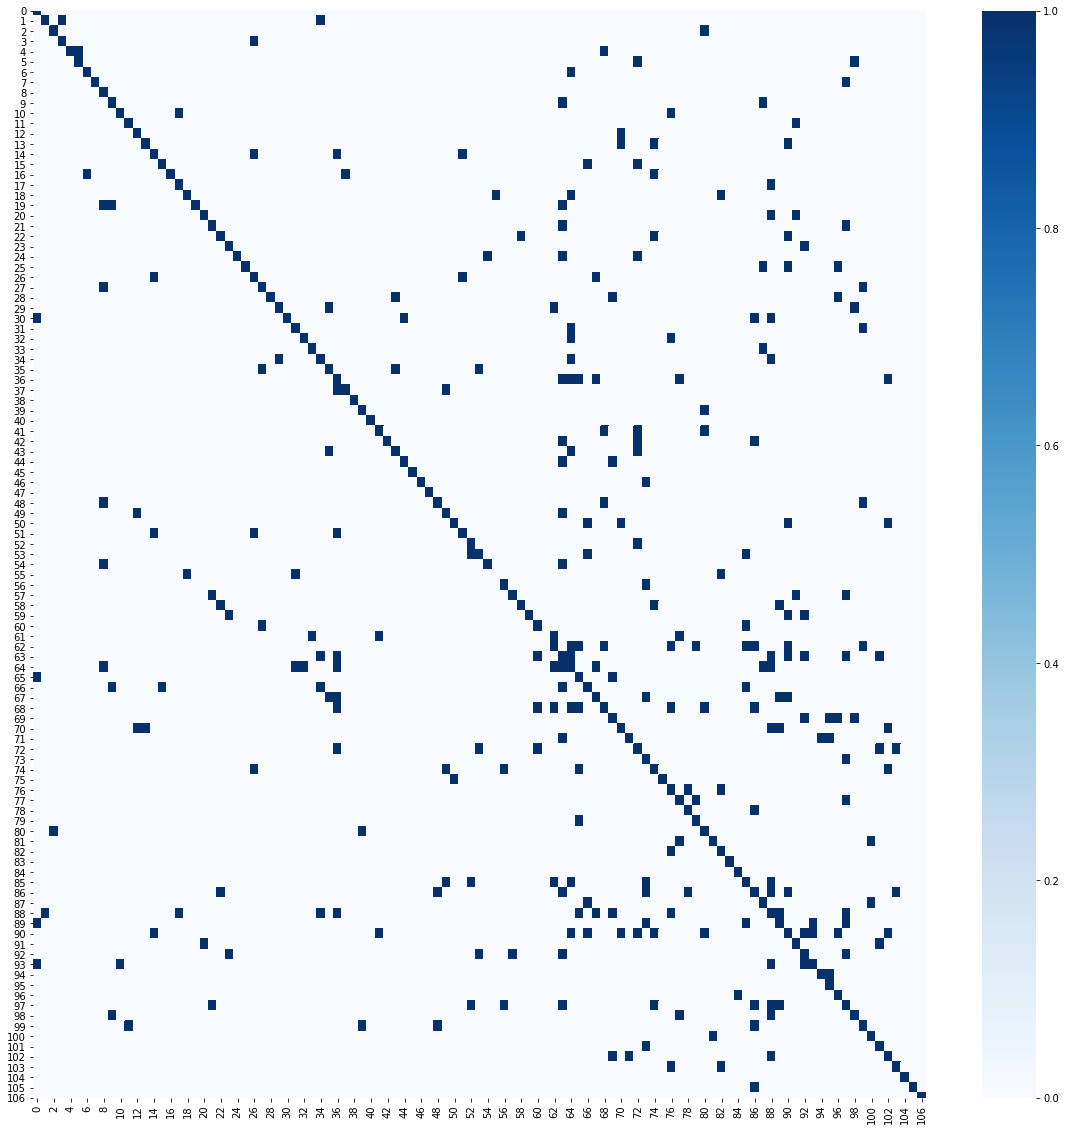

In [263]:
# Spectral Color Map used: Violet means 1, Red means -1 and Yellow means 0
cfs1 = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20,20))
sn.heatmap(cfs1, cmap="Blues", robust=True)
plt.show()

Multiclass Precision, Recall and Accuracy

In [264]:
cr1 = classification_report(y_true, y_pred, digits=2)
print(cr1)
cr1 = classification_report(y_true, y_pred, digits=4, output_dict=True)

              precision    recall  f1-score   support

           0       0.80      1.00      0.89        16
           1       0.80      0.67      0.73         6
           2       0.91      0.77      0.83        13
           3       0.83      0.83      0.83         6
           4       1.00      0.60      0.75         5
           5       0.80      0.67      0.73         6
           6       0.92      0.92      0.92        12
           7       1.00      0.83      0.91         6
           8       0.67      1.00      0.80        10
           9       0.73      0.80      0.76        10
          10       0.89      0.80      0.84        10
          11       0.91      0.91      0.91        11
          12       0.73      0.92      0.81        12
          13       0.83      0.50      0.62        10
          14       0.57      0.50      0.53         8
          15       0.80      0.57      0.67         7
          16       1.00      0.57      0.73         7
          17       0.78    

In [265]:
# Use this line before each model training to save memory
del model1, history1, tensorboard_callback1, res

## Model 2: CNN 2 without Batch Normalization

In [169]:
K.clear_session()

In [170]:
# optimizer
lr = 0.01
mtn=0.9
optimizer = SGD(lr=lr, momentum=mtn)
# optimizer = RMSprop(lr=lr)

# loss function
loss = 'categorical_crossentropy'

batch_size = 512
epochs = 30

In [171]:
# create network
model2 = create_network2(input_shape, data_format, num_classes)
# compile network
model2.compile(loss=loss, optimizer=optimizer, metrics = ['accuracy'])

In [172]:
# Model 2 Summary
print('Model 2 summary')
print(model2.summary())
# plot_model(model2, to_file=model_dir+'model2.png')

Model 2 summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 25, 32, 32)        650       
_________________________________________________________________
activation_1 (Activation)    (None, 25, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 16, 16)        11300     
_________________________________________________________________
activation_2 (Activation)    (None, 50, 16, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 8, 8)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 8, 8)         20100

In [173]:
# Fit dataset
tensorboard_callback2 = keras.callbacks.TensorBoard(os.path.join(model_dir+'logs','model2'))
history2 = model2.fit(X_train, 
                      y_train, 
                      validation_data=(X_test, y_test), 
                      batch_size=batch_size, 
                      epochs=epochs, 
                      verbose=1, 
                      callbacks=[tensorboard_callback2])
model2.save(model_dir+'model2.h5')
print(f"Training completed on {datetime.datetime.now().strftime('%Y-%m-%d, %H-%M')}")

# store logs to csv file
df_history2 = pd.DataFrame(data=history2.history)
df_history2.to_csv(model_logs+'logs_model2.csv')

Train on 38484 samples, validate on 4276 samples
Epoch 1/30
38484/38484 [==============================] - 5s 141us/step - loss: 4.1694 - acc: 0.0592 - val_loss: 3.9533 - val_acc: 0.0716
Epoch 2/30
38484/38484 [==============================] - 4s 116us/step - loss: 3.8114 - acc: 0.1109 - val_loss: 3.1337 - val_acc: 0.2993
Epoch 3/30
38484/38484 [==============================] - 4s 116us/step - loss: 2.1652 - acc: 0.5048 - val_loss: 1.3114 - val_acc: 0.6819
Epoch 4/30
38484/38484 [==============================] - 4s 116us/step - loss: 1.0234 - acc: 0.7465 - val_loss: 0.7771 - val_acc: 0.8066
Epoch 5/30
38484/38484 [==============================] - 4s 116us/step - loss: 0.6659 - acc: 0.8297 - val_loss: 0.5823 - val_acc: 0.8454
Epoch 6/30
38484/38484 [==============================] - 4s 116us/step - loss: 0.5132 - acc: 0.8681 - val_loss: 0.4959 - val_acc: 0.8739
Epoch 7/30
38484/38484 [==============================] - 4s 116us/step - loss: 0.4061 - acc: 0.8939 - val_loss: 0.4230 - v

Metrics

In [174]:
model2 = load_model(model_dir+'model2.h5')

In [175]:
res = model2.predict(X_test)

In [176]:
# convert predictions from one hot encoded to label value
y_pred = convert_pred_list_ohe_to_labels(res, threshold=0.1, get_max=True)
# convert test values from one hot encoded to label value
y_true = convert_pred_list_ohe_to_labels(y_test, threshold=0.9, get_max=True)

Confusion Matrix

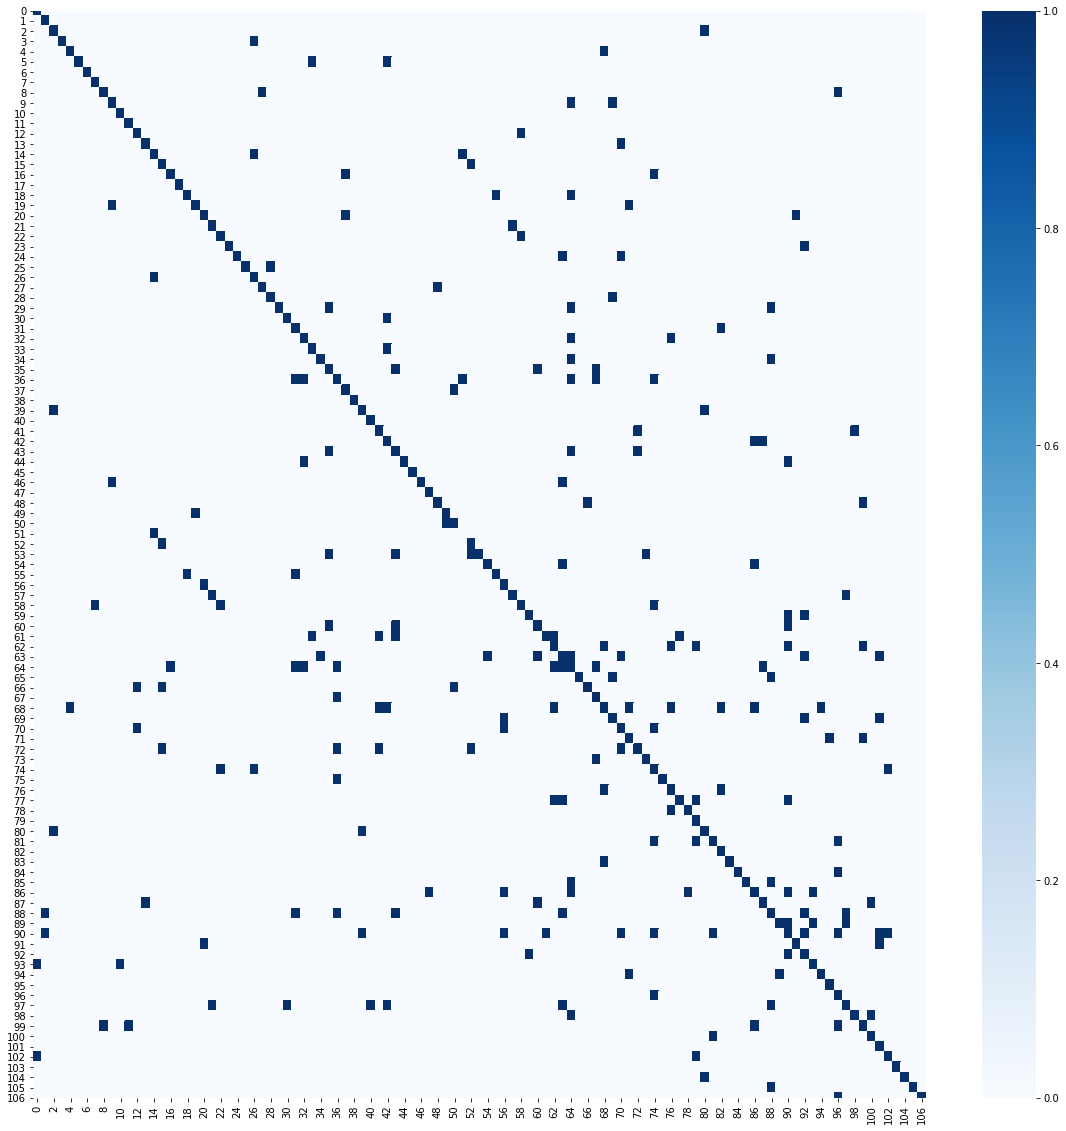

In [177]:
# Spectral Color Map used: Violet means 1, Red means -1 and Yellow means 0
cfs2 = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20,20))
sn.heatmap(cfs2, cmap="Blues", robust=True)
plt.show()

Multiclass Precision, Recall and Accuracy

In [178]:
cr2 = classification_report(y_true, y_pred, digits=2)
print(cr2)
cr2 = classification_report(y_true, y_pred, digits=4, output_dict=True)

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        16
           1       0.75      1.00      0.86         6
           2       0.57      0.92      0.71        13
           3       1.00      0.83      0.91         6
           4       0.80      0.80      0.80         5
           5       1.00      0.67      0.80         6
           6       1.00      1.00      1.00        12
           7       0.86      1.00      0.92         6
           8       0.89      0.80      0.84        10
           9       0.80      0.80      0.80        10
          10       0.91      1.00      0.95        10
          11       0.92      1.00      0.96        11
          12       0.85      0.92      0.88        12
          13       0.90      0.90      0.90        10
          14       0.29      0.62      0.40         8
          15       0.42      0.71      0.53         7
          16       0.83      0.71      0.77         7
          17       1.00    

In [179]:
# Use this line before each model training to save memory
del model2, history2, tensorboard_callback2, res

## Model 3: CNN 2 with Batch Normalization

In [180]:
K.clear_session()

In [181]:
# optimizer
lr = 0.01
mtn=0.9
optimizer = SGD(lr=lr, momentum=mtn)
# optimizer = RMSprop(lr=lr)

# loss function
loss = 'categorical_crossentropy'

batch_size = 512
epochs = 30

In [182]:
# create network
model3 = create_network3(input_shape, data_format, num_classes)
# compile network
model3.compile(loss=loss, optimizer=optimizer, metrics = ['accuracy'])

Model 3 Summary

In [183]:
print(model3.summary())
# plot_model(model3, to_file=model_dir+'model3.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 25, 32, 32)        650       
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 25, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 16, 16)        11300     
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 16, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 50, 16, 16)        0         
__________

In [184]:
# Fit dataset
tensorboard_callback3 = keras.callbacks.TensorBoard(os.path.join(model_dir+'logs','model3'))
history3 = model3.fit(X_train, 
                      y_train, 
                      validation_data=(X_test, y_test), 
                      batch_size=batch_size, 
                      epochs=epochs, 
                      verbose=1, 
                      callbacks=[tensorboard_callback3])
model3.save(model_dir+'model3.h5')
print(f"Training completed on {datetime.datetime.now().strftime('%Y-%m-%d, %H-%M')}")

# store logs to csv file
df_history3 = pd.DataFrame(data=history3.history)
df_history3.to_csv(model_logs+'logs_model3.csv')

Train on 38484 samples, validate on 4276 samples
Epoch 1/30
38484/38484 [==============================] - 7s 194us/step - loss: 2.3785 - acc: 0.4783 - val_loss: 1.2326 - val_acc: 0.7142
Epoch 2/30
38484/38484 [==============================] - 6s 168us/step - loss: 0.6291 - acc: 0.8448 - val_loss: 0.4481 - val_acc: 0.8840
Epoch 3/30
38484/38484 [==============================] - 6s 168us/step - loss: 0.3645 - acc: 0.9068 - val_loss: 0.3577 - val_acc: 0.9095
Epoch 4/30
38484/38484 [==============================] - 6s 168us/step - loss: 0.2764 - acc: 0.9281 - val_loss: 0.2989 - val_acc: 0.9266
Epoch 5/30
38484/38484 [==============================] - 6s 166us/step - loss: 0.2342 - acc: 0.9372 - val_loss: 0.2804 - val_acc: 0.9315
Epoch 6/30
38484/38484 [==============================] - 6s 167us/step - loss: 0.1954 - acc: 0.9476 - val_loss: 0.2474 - val_acc: 0.9394
Epoch 7/30
38484/38484 [==============================] - 6s 167us/step - loss: 0.1630 - acc: 0.9559 - val_loss: 0.2718 - v

Metrics

In [185]:
# to load model use
model3 = load_model(model_dir+'model3.h5')

In [186]:
res = model3.predict(X_test)

In [187]:
# convert predictions from one hot encoded to label value
y_pred = convert_pred_list_ohe_to_labels(res, threshold=0.1, get_max=True)
# convert test values from one hot encoded to label value
y_true = convert_pred_list_ohe_to_labels(y_test, threshold=0.9, get_max=True)

Confusion Matrix

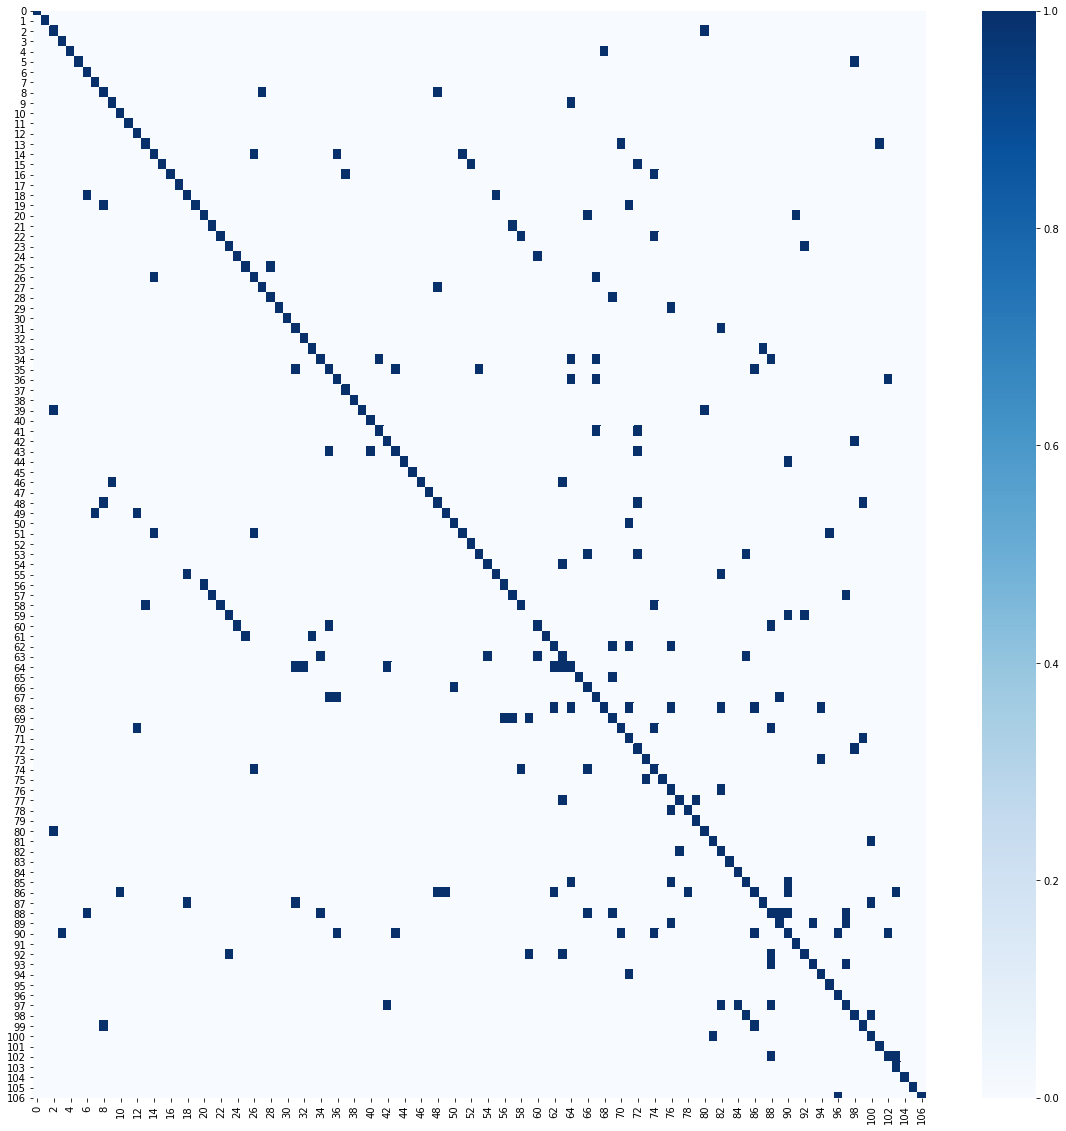

In [188]:
# Spectral Color Map used: Violet means 1, Red means -1 and Yellow means 0
cfs3 = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20,20))
sn.heatmap(cfs3, cmap="Blues", robust=True)

Muticlass Precision, Recall and Accuracy

In [189]:
cr3 = classification_report(y_true, y_pred, digits=2)
print(cr3)
cr3 = classification_report(y_true, y_pred, digits=4, output_dict=True)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         6
           2       0.86      0.92      0.89        13
           3       0.86      1.00      0.92         6
           4       1.00      0.80      0.89         5
           5       1.00      0.83      0.91         6
           6       0.86      1.00      0.92        12
           7       0.86      1.00      0.92         6
           8       0.73      0.80      0.76        10
           9       0.90      0.90      0.90        10
          10       0.91      1.00      0.95        10
          11       1.00      1.00      1.00        11
          12       0.86      1.00      0.92        12
          13       0.89      0.80      0.84        10
          14       0.43      0.38      0.40         8
          15       1.00      0.71      0.83         7
          16       1.00      0.71      0.83         7
          17       1.00    

In [190]:
# Use this line before each model training to save memory
del model3, history3, tensorboard_callback3, res

# ANN

In [207]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
config.gpu_options.per_process_gpu_memory_fraction=0.5
sess = tf.Session(config=config)
K.set_session(sess)

Split Set for ANN models

In [208]:
# input shape of dataset
input_shape = (32 * 32,)
print("CNN Input Shape is", input_shape)

# define the channels location
data_format = 'channels_first'

X_train, X_test, y_train, y_test = process_x_y_train_test_stratified_ann(train, test, input_shape=input_shape)

CNN Input Shape is (1024,)


## Model 4: ANN without regularization

In [244]:
K.clear_session()
# optimizer
lr = 0.01
mtn=0.95
optimizer = SGD(lr=lr, momentum=mtn)
# optimizer = RMSprop(lr=lr)

# loss function
loss = 'categorical_crossentropy'

batch_size = 512
epochs = 50

In [245]:
# create network
model4 = create_network_ann1(input_shape, num_classes)
# compile network
model4.compile(loss=loss, optimizer=optimizer, metrics = ['accuracy'])

Model Summary

In [246]:
print(model4.summary())
#plot_model(model4, to_file=dir_+'model4.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
activation_2 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              2099200   
__________

In [247]:
# Fit dataset
tensorboard_callback4 = keras.callbacks.TensorBoard(os.path.join(model_dir+'logs','model4'))
history4 = model4.fit(X_train, 
                      y_train, 
                      validation_data=(X_test, y_test), 
                      batch_size=batch_size, 
                      epochs=epochs, 
                      verbose=1, 
                      callbacks=[tensorboard_callback4])
model4.save(model_dir+'model4.h5')
print(f"Training completed on {datetime.datetime.now().strftime('%Y-%m-%d, %H-%M')}")

# store logs to csv file
df_history4 = pd.DataFrame(data=history4.history)
df_history4.to_csv(model_logs+'logs_model4.csv')

Train on 38484 samples, validate on 4276 samples
Epoch 1/50
38484/38484 [==============================] - 2s 48us/step - loss: 3.3530 - acc: 0.2708 - val_loss: 2.0885 - val_acc: 0.5463
Epoch 2/50
38484/38484 [==============================] - 1s 34us/step - loss: 1.7043 - acc: 0.6236 - val_loss: 1.2426 - val_acc: 0.7142
Epoch 3/50
38484/38484 [==============================] - 1s 34us/step - loss: 1.2398 - acc: 0.7104 - val_loss: 0.9923 - val_acc: 0.7629
Epoch 4/50
38484/38484 [==============================] - 1s 34us/step - loss: 1.0355 - acc: 0.7470 - val_loss: 0.8715 - val_acc: 0.7895
Epoch 5/50
38484/38484 [==============================] - 1s 34us/step - loss: 0.8914 - acc: 0.7765 - val_loss: 0.8018 - val_acc: 0.8057
Epoch 6/50
38484/38484 [==============================] - 1s 34us/step - loss: 0.7888 - acc: 0.8026 - val_loss: 0.7245 - val_acc: 0.8260
Epoch 7/50
38484/38484 [==============================] - 1s 34us/step - loss: 0.7329 - acc: 0.8132 - val_loss: 0.6655 - val_acc:

Metrics

In [248]:
# to load model use
model4 = load_model(model_dir+'model4.h5')

In [249]:
res = model4.predict(X_test)

In [250]:
# convert predictions from one hot encoded to label value
y_pred = convert_pred_list_ohe_to_labels(res, threshold=0.001, get_max=True)
# convert test values from one hot encoded to label value
y_true = convert_pred_list_ohe_to_labels(y_test, threshold=0.9, get_max=True)

Confusion Matrix

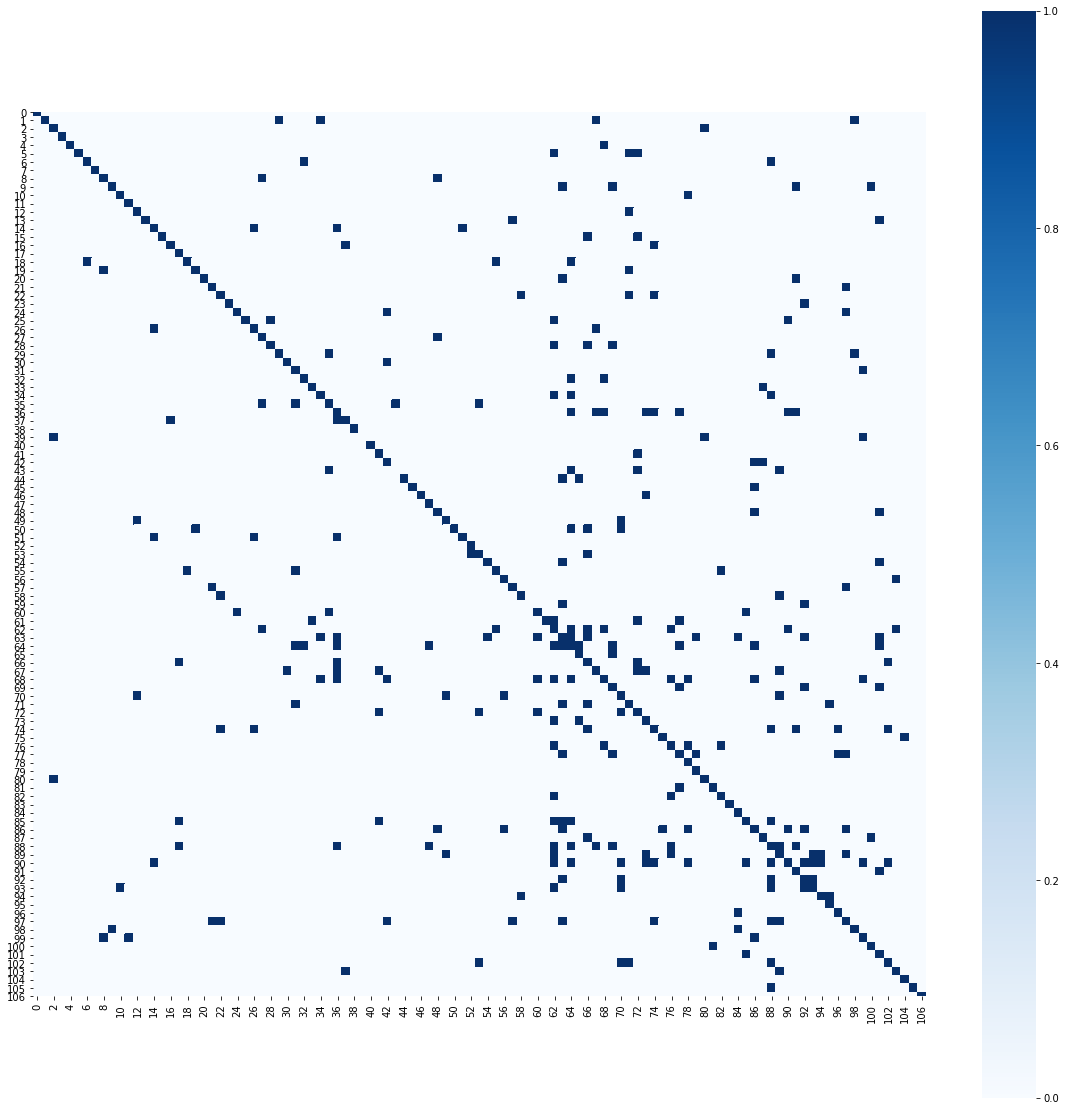

In [251]:
# Spectral Color Map used: Violet means 1, Red means -1 and Yellow means 0
cfs4 = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20,20))
sn.heatmap(cfs4, cmap="Blues", robust=True, square=True)
plt.show()

Multiclass Precision, Recall and Accuracy

In [252]:
cr4 = classification_report(y_true, y_pred, digits=2)
print(cr4)
cr4 = classification_report(y_true, y_pred, digits=4, output_dict=True)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.33      0.50         6
           2       0.79      0.85      0.81        13
           3       1.00      1.00      1.00         6
           4       1.00      0.80      0.89         5
           5       1.00      0.50      0.67         6
           6       0.91      0.83      0.87        12
           7       1.00      1.00      1.00         6
           8       0.80      0.80      0.80        10
           9       0.86      0.60      0.71        10
          10       0.90      0.90      0.90        10
          11       0.92      1.00      0.96        11
          12       0.79      0.92      0.85        12
          13       1.00      0.80      0.89        10
          14       0.33      0.25      0.29         8
          15       1.00      0.57      0.73         7
          16       0.83      0.71      0.77         7
          17       0.73    

In [253]:
# Use this line before each model training to save memory
del model4, history4, tensorboard_callback4, res

## Model 5: ANN with regularization

In [234]:
K.clear_session()
# optimizer
lr = 0.01
mtn=0.9
optimizer = SGD(lr=lr, momentum=mtn)
# optimizer = RMSprop(lr=lr)

# loss function
loss = 'categorical_crossentropy'

batch_size = 128
epochs = 50

In [235]:
# create network
model5 = create_network_ann2(input_shape, num_classes)
# compile network
model5.compile(loss=loss, optimizer=optimizer, metrics = ['accuracy'])

Model Summary

In [236]:
print(model5.summary())
#plot_model(model5, to_file=dir_+'model5.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
activation_2 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              2099200   
__________

In [237]:
# Fit dataset
tensorboard_callback5 = keras.callbacks.TensorBoard(os.path.join(model_dir+'logs','model5'))
history5 = model5.fit(X_train, 
                      y_train, 
                      validation_data=(X_test, y_test), 
                      batch_size=batch_size, 
                      epochs=epochs, 
                      verbose=1, 
                      callbacks=[tensorboard_callback5])
model5.save(model_dir+'model5.h5')
print(f"Training completed on {datetime.datetime.now().strftime('%Y-%m-%d, %H-%M')}")

# store logs to csv file
df_history5 = pd.DataFrame(data=history5.history)
df_history5.to_csv(model_logs+'logs_model5.csv')

Train on 38484 samples, validate on 4276 samples
Epoch 1/50
38484/38484 [==============================] - 4s 116us/step - loss: 27.0259 - acc: 0.5062 - val_loss: 14.3673 - val_acc: 0.6763
Epoch 2/50
38484/38484 [==============================] - 3s 85us/step - loss: 9.0958 - acc: 0.6883 - val_loss: 5.5372 - val_acc: 0.7025
Epoch 3/50
38484/38484 [==============================] - 3s 85us/step - loss: 3.9557 - acc: 0.7077 - val_loss: 2.8371 - val_acc: 0.7299
Epoch 4/50
38484/38484 [==============================] - 3s 86us/step - loss: 2.4254 - acc: 0.7153 - val_loss: 2.0086 - val_acc: 0.7378
Epoch 5/50
38484/38484 [==============================] - 3s 85us/step - loss: 1.9412 - acc: 0.7227 - val_loss: 1.7677 - val_acc: 0.7526
Epoch 6/50
38484/38484 [==============================] - 3s 85us/step - loss: 1.7744 - acc: 0.7295 - val_loss: 1.7197 - val_acc: 0.7339
Epoch 7/50
38484/38484 [==============================] - 3s 85us/step - loss: 1.6964 - acc: 0.7366 - val_loss: 1.8780 - val_a

Metrics

In [238]:
# to load model use
model5 = load_model(model_dir+'model5.h5')

In [239]:
res = model5.predict(X_test)

In [240]:
# convert predictions from one hot encoded to label value
y_pred = convert_pred_list_ohe_to_labels(res, threshold=0.001, get_max=True)
# convert test values from one hot encoded to label value
y_true = convert_pred_list_ohe_to_labels(y_test, threshold=0.9, get_max=True)

Confusion Matrix

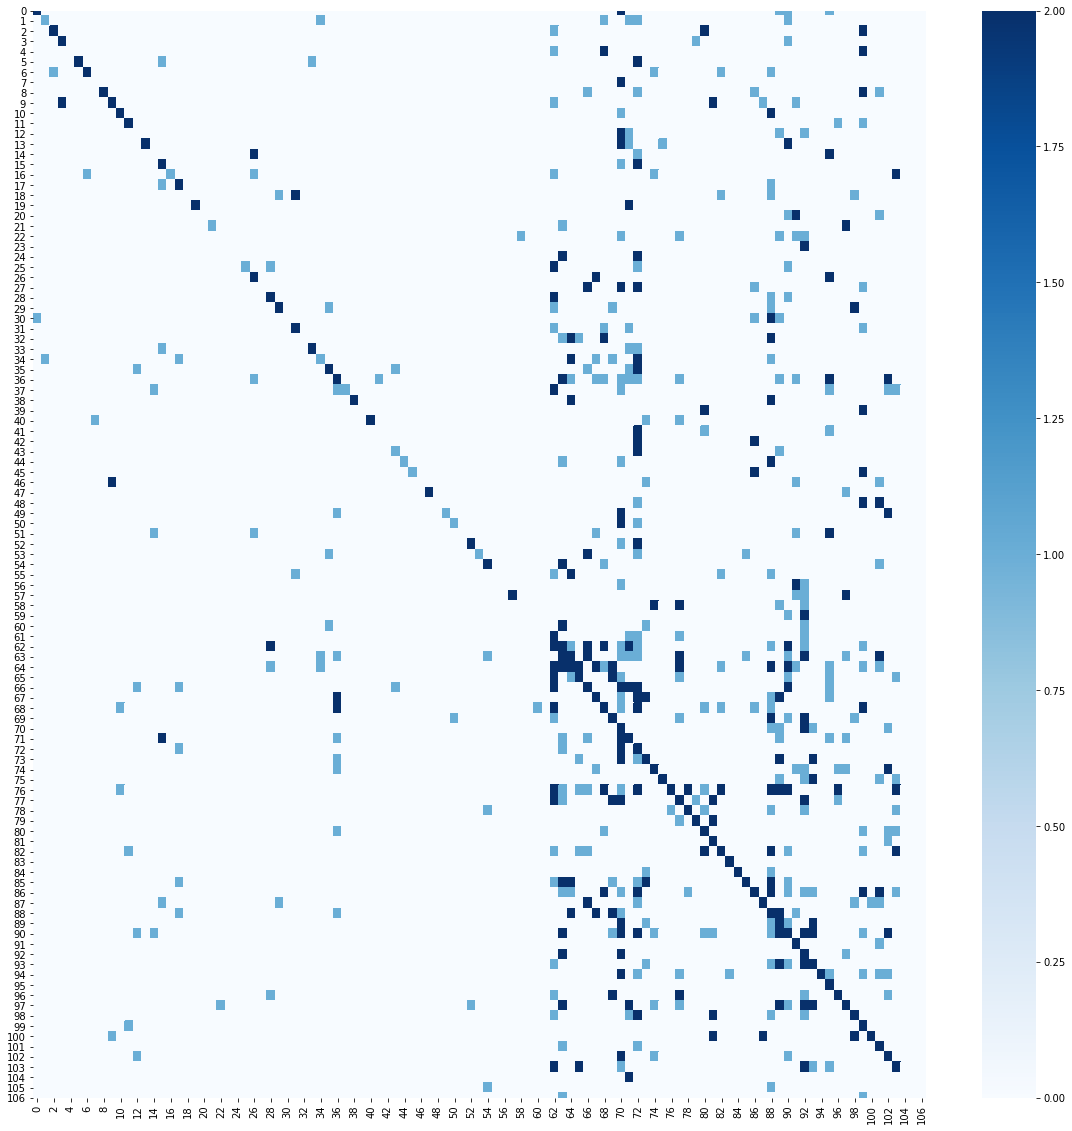

In [241]:
# Spectral Color Map used: Violet means 1, Red means -1 and Yellow means 0
cfs5 = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20,20))
sn.heatmap(cfs5, cmap="Blues", robust=True)
plt.show()

Multiclass Precision, Recall and Accuracy

In [242]:
cr5 = classification_report(y_true, y_pred, digits=2)
print(cr5)
cr5 = classification_report(y_true, y_pred, digits=4, output_dict=True)

              precision    recall  f1-score   support

           0       0.91      0.62      0.74        16
           1       0.50      0.17      0.25         6
           2       0.80      0.31      0.44        13
           3       0.67      0.67      0.67         6
           4       0.00      0.00      0.00         5
           5       1.00      0.33      0.50         6
           6       0.89      0.67      0.76        12
           7       0.00      0.00      0.00         6
           8       1.00      0.20      0.33        10
           9       0.40      0.20      0.27        10
          10       0.67      0.40      0.50        10
          11       0.82      0.82      0.82        11
          12       0.00      0.00      0.00        12
          13       1.00      0.20      0.33        10
          14       0.00      0.00      0.00         8
          15       0.33      0.43      0.38         7
          16       1.00      0.14      0.25         7
          17       0.55    

In [243]:
# Use this line before each model training to save memory
del model5, history5, tensorboard_callback5, res

# CNN (contd)

## Model 6: LeNet

In [191]:
K.clear_session()

In [196]:
# optimizer
lr = 0.01
mtn=0.9

# optimizer = RMSprop(lr=lr)
# optimizer = SGD(lr=lr, momentum=mtn)
optimizer = Adam()

# loss function
loss = 'categorical_crossentropy'

batch_size = 512
epochs = 30

In [197]:
# create network
model6 = create_network6(input_shape, num_classes)
# compile network
model6.compile(loss=loss, optimizer=optimizer, metrics = ['accuracy'])

Model Summary

In [198]:
print(model6.summary())
#plot_model(model6, to_file=dir_+'model6.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 6, 32, 32)         156       
_________________________________________________________________
activation_7 (Activation)    (None, 6, 32, 32)         0         
_________________________________________________________________
average_pooling2d_3 (Average (None, 6, 31, 31)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 27, 27)        2416      
_________________________________________________________________
activation_8 (Activation)    (None, 16, 27, 27)        0         
_________________________________________________________________
average_pooling2d_4 (Average (None, 16, 13, 13)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 120, 9, 9)         48120     
__________

In [199]:
# Fit dataset
tensorboard_callback6 = keras.callbacks.TensorBoard(os.path.join(model_dir+'logs','model6'))
history6 = model6.fit(X_train, 
                      y_train, 
                      validation_data=(X_test, y_test), 
                      batch_size=batch_size, 
                      epochs=epochs, 
                      verbose=1, 
                      callbacks=[tensorboard_callback6])
model6.save(model_dir+'model6.h5')
print(f"Training completed on {datetime.datetime.now().strftime('%Y-%m-%d, %H-%M')}")

# store logs to csv file
df_history6 = pd.DataFrame(data=history6.history)
df_history6.to_csv(model_logs+'logs_model6.csv')

Train on 38484 samples, validate on 4276 samples
Epoch 1/30
38484/38484 [==============================] - 7s 179us/step - loss: 2.1216 - acc: 0.5380 - val_loss: 1.0998 - val_acc: 0.7463
Epoch 2/30
38484/38484 [==============================] - 6s 155us/step - loss: 0.9790 - acc: 0.7691 - val_loss: 0.7583 - val_acc: 0.8246
Epoch 3/30
38484/38484 [==============================] - 6s 156us/step - loss: 0.7105 - acc: 0.8298 - val_loss: 0.6674 - val_acc: 0.8471
Epoch 4/30
38484/38484 [==============================] - 6s 157us/step - loss: 0.5865 - acc: 0.8567 - val_loss: 0.5727 - val_acc: 0.8662
Epoch 5/30
38484/38484 [==============================] - 6s 157us/step - loss: 0.4750 - acc: 0.8818 - val_loss: 0.5167 - val_acc: 0.8756
Epoch 6/30
38484/38484 [==============================] - 6s 154us/step - loss: 0.4132 - acc: 0.8959 - val_loss: 0.4995 - val_acc: 0.8803
Epoch 7/30
38484/38484 [==============================] - 6s 156us/step - loss: 0.3506 - acc: 0.9105 - val_loss: 0.4352 - v

Metrics

In [200]:
# to load model use
model6 = load_model(model_dir+'model6.h5')

In [201]:
res = model6.predict(X_test)

In [202]:
# convert predictions from one hot encoded to label value
y_pred = convert_pred_list_ohe_to_labels(res, threshold=0.001, get_max=True)
# convert test values from one hot encoded to label value
y_true = convert_pred_list_ohe_to_labels(y_test, threshold=0.9, get_max=True)

Confusion Matrix

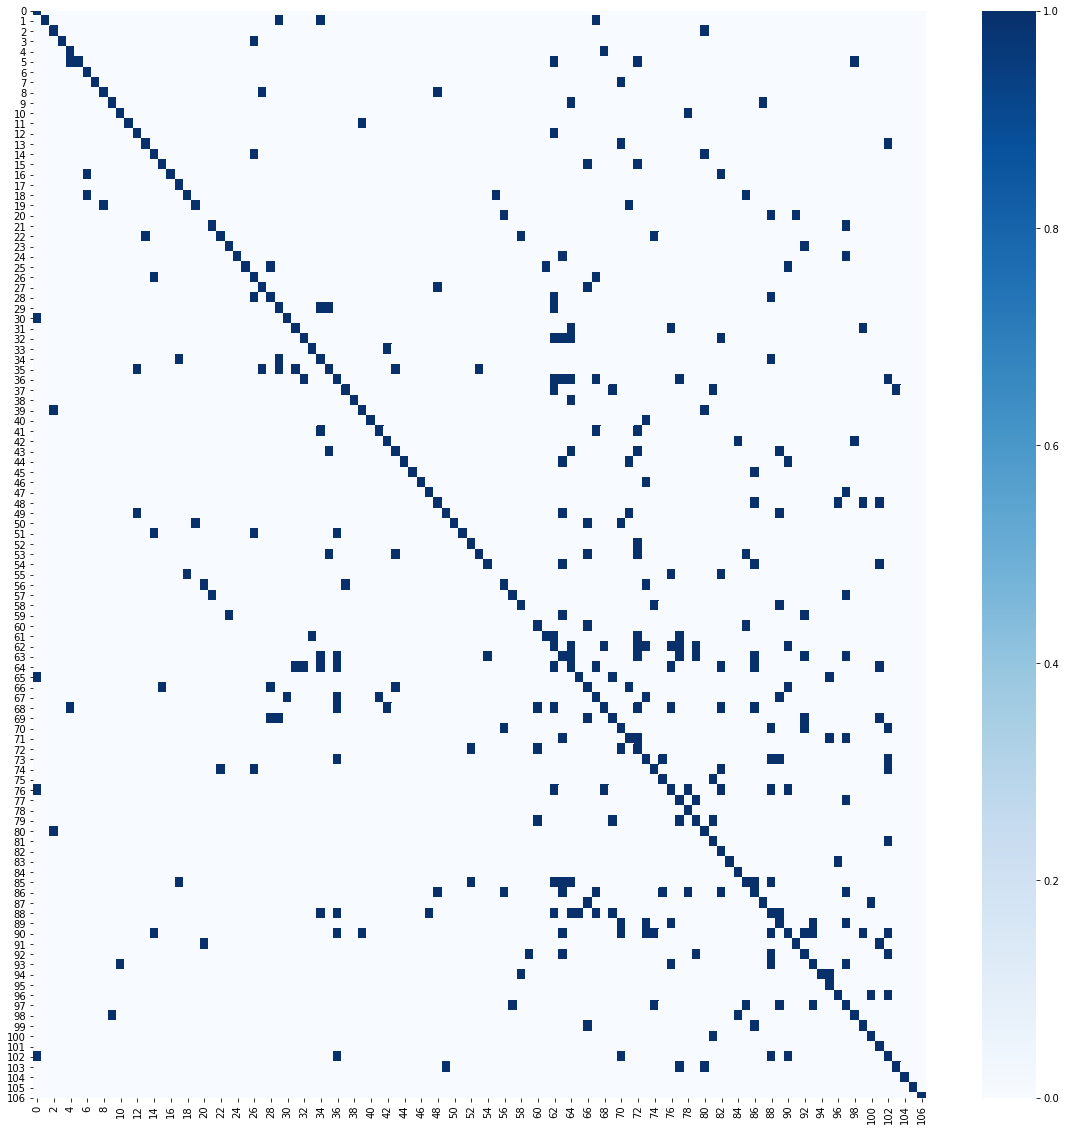

In [203]:
# Spectral Color Map used: Violet means 1, Red means -1 and Yellow means 0
cfs6 = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20,20))
sn.heatmap(cfs6, cmap="Blues", robust=True)
plt.show()

Multiclass Precision, Recall and Accuracy

In [204]:
cr6 = classification_report(y_true, y_pred, digits=2)
print(cr6)
cr6 = classification_report(y_true, y_pred, digits=4, output_dict=True)

              precision    recall  f1-score   support

           0       0.80      1.00      0.89        16
           1       1.00      0.50      0.67         6
           2       0.83      0.77      0.80        13
           3       1.00      0.83      0.91         6
           4       0.57      0.80      0.67         5
           5       1.00      0.33      0.50         6
           6       0.86      1.00      0.92        12
           7       1.00      0.67      0.80         6
           8       0.88      0.70      0.78        10
           9       0.89      0.80      0.84        10
          10       0.90      0.90      0.90        10
          11       1.00      0.91      0.95        11
          12       0.79      0.92      0.85        12
          13       0.88      0.70      0.78        10
          14       0.45      0.62      0.53         8
          15       0.80      0.57      0.67         7
          16       1.00      0.71      0.83         7
          17       0.80    

In [205]:
# Use this line before each model training to save memory
del model6, history6, tensorboard_callback6, res

## T Test (Comparison Test)

In [23]:
X_test.shape

(4276, 1, 32, 32)

In [46]:
def t_test(test_x, test_y, models, sym2latex_dict):
    if len(models) < 0:
        raise ValueError("No models found in models variable")
    if len(test_x) != len(test_y):
        raise ValueError("Varibales test_x and test_y are of different length")
    
    # convert test values from one hot encoded to label value
    y_true = []
    for i in range(len(test_y)):
        # print(one_hot_encode_to_char(res[i], threshold = 0.5, get_max=False))
        val = one_hot_encode_to_char(test_y[i], threshold = 0.9, get_max=True)
        if len(val) > 0:
            y_true.append(val[0])
        else:
            y_true.append(None)
            print(":(")
    
    # test_x_ann for ann with shape (samples, 32*32)
    # test_x for cnn with shape (samples, 1, 32, 32)
    test_x_ann = test_x.reshape(test_x.shape[0], test_x.shape[-1] * test_x.shape[-2])
    no_models = len(models)
    cols = ['symbol','latex']
    preds = []
    # convert predictions from one hot encoded to label value
    for i in range(no_models):
        print("Predictng labels for Model "+str(i+1))
        cols.append('model'+str(i+1))
        
        # check if model is cnn or ann with a cnn flag
        if models[i][1] == 1:
            res = models[i][0].predict(test_x)
        else:
            res = models[i][0].predict(test_x_ann)
        
        y_pred = []
        for j in range(len(res)):
            # print(one_hot_encode_to_char(res[i], threshold = 0.5, get_max=False))
            val = one_hot_encode_to_char(res[j], threshold = 0.1, get_max=True)
            if len(val) > 0:
                y_pred.append(val[0])
            else:
                y_pred.append(None)
                print(":(")
        preds.append(y_pred)
    print("Predictions Done")
    print("Comparing Results...")
    
    # perform t test
    t_test_result = pd.DataFrame(columns=cols)
    for i in range(len(y_true)):
        t_test_result.loc[i,'symbol'] = y_true[i]
        t_test_result.loc[i,'latex'] = sym2latex_dict[y_true[i]]
        for j in range(no_models):
            t_test_result.loc[i, 'model'+str(j+1)] = sym2latex_dict[preds[j][i]]
    print("Done")    
    return t_test_result

def create_t_test_report(test_res):
    models_names = list(test_res.columns.values[2:])
    res = pd.DataFrame(columns=['latex','total_count']+models_names)
    for i in range(len(symbols)):
        res.loc[i,'latex'] = symbols.loc[i,'latex']
        res.loc[i,'total_count'] = 0
        for j in models_names:
            res.loc[i,j] = 0
    for i in range(len(test_res)):
        res.loc[test_res.loc[i,'symbol'],'total_count'] += 1
        for j in models_names:
            if test_res.loc[i,'latex'] == test_res.loc[i,j]:
                res.loc[latex2sym[test_res.loc[i,j]],j] += 1
    for i in range(len(res)):
        for j in models_names:
            res.loc[i,j+'_acc'] = round((res.loc[i,j]/res.loc[i,'total_count']) * 100, 2)
    return res

In [47]:
sym2latex = {i.Index : i.latex for i in symbols.itertuples()}
latex2sym = {v: k for k, v in sym2latex.items()}

In [48]:

ms = [
    ('model1.h5', 1),
    ('model2.h5', 1),
    ('model3.h5', 1),
    ('model4.h5', 0),
    ('model5.h5', 0),
    ('model6.h5', 1),
]
models = [(load_model(model_dir+i_[0]), i_[1]) for i_ in ms]
"""
ms = [('model6.h5', 1)]
models = [(load_model(model_dir+i_[0]), i_[1]) for i_ in ms]
"""

"\nms = [('model6.h5', 1)]\nmodels = [(load_model(model_dir+i_[0]), i_[1]) for i_ in ms]\n"

In [49]:
ttest = t_test(X_test, y_test, models=models, sym2latex_dict=sym2latex)
ttest.head()

Predictng labels for Model 1
Predictng labels for Model 2
Predictng labels for Model 3
Predictng labels for Model 4
Predictng labels for Model 5
Predictng labels for Model 6
Predictions Done
Comparing Results...
Done


,symbol,latex,model1,model2,model3,model4,model5,model6
0,80,\subset,\subset,\subset,\subset,\subset,\subset,\subset
1,81,\supset,\supset,\supset,\supset,\supset,\supset,\supset
2,74,\omega,1,0,0,0,\theta,0
3,63,\gamma,\gamma,\gamma,\gamma,\gamma,\gamma,\gamma
4,101,\|,\|,\|,\|,\|,\|,\|


In [50]:
t_test_report = create_t_test_report(ttest)
t_test_report.head()

,latex,total_count,model1,model2,model3,model4,model5,model6,model1_acc,model2_acc,model3_acc,model4_acc,model5_acc,model6_acc
0,A,16,16,15,16,16,13,16,100.00,93.75,100.00,100.00,81.25,100.00
1,B,6,2,4,5,2,0,3,33.33,66.67,83.33,33.33,0.00,50.00
2,C,13,11,11,11,9,0,11,84.62,84.62,84.62,69.23,0.00,84.62
3,D,6,6,5,6,6,3,5,100.00,83.33,100.00,100.00,50.00,83.33
4,E,5,4,4,4,4,0,3,80.00,80.00,80.00,80.00,0.00,60.00


# Plots

#### Train-Test Accuracy plots

In [305]:
df_history1 = pd.read_csv(model_logs+'logs_model1.csv').drop(['Unnamed: 0'], axis=1).reset_index(drop=True)
df_history2 = pd.read_csv(model_logs+'logs_model2.csv').drop(['Unnamed: 0'], axis=1).reset_index(drop=True)
df_history3 = pd.read_csv(model_logs+'logs_model3.csv').drop(['Unnamed: 0'], axis=1).reset_index(drop=True)
df_history4 = pd.read_csv(model_logs+'logs_model4.csv').drop(['Unnamed: 0'], axis=1).reset_index(drop=True)
df_history5 = pd.read_csv(model_logs+'logs_model5.csv').drop(['Unnamed: 0'], axis=1).reset_index(drop=True)
df_history6 = pd.read_csv(model_logs+'logs_model6.csv').drop(['Unnamed: 0'], axis=1).reset_index(drop=True)

In [337]:
def draw_train_test_plot(df_, modelno=0):
    plt.figure(figsize=(10, 5))
    plt.plot(df_['acc'], label='Train Accuracy')
    plt.plot(df_['val_acc'], label='Validation Accuracy')
    plt.title(f'Train Validation Accuracy Plot for Model {modelno}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1.05])
    plt.legend(loc='lower right')
    plt.savefig(plot_dir+f'train_test_plot_model_{modelno}', bbox_inches='tight')
    plt.show()

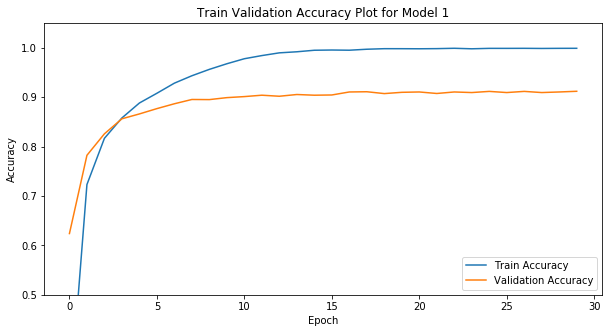

In [338]:
draw_train_test_plot(df_history1, 1)

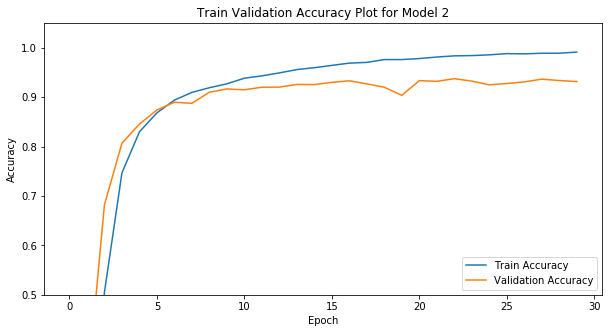

In [339]:
draw_train_test_plot(df_history2, 2)

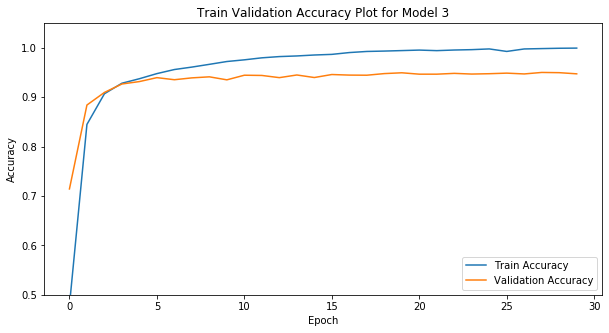

In [340]:
draw_train_test_plot(df_history3, 3)

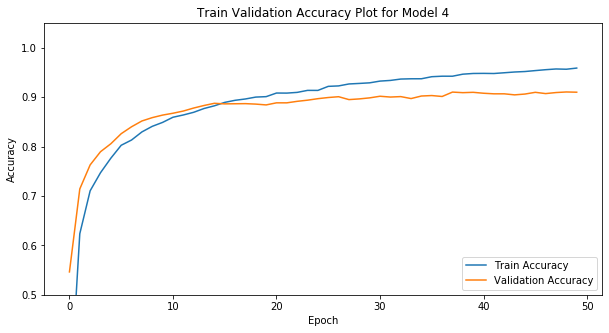

In [341]:
draw_train_test_plot(df_history4, 4)

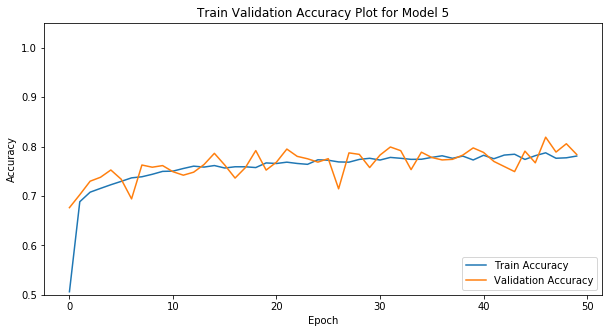

In [342]:
draw_train_test_plot(df_history5, 5)

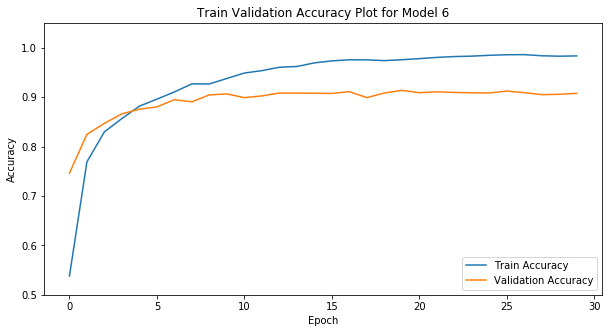

In [343]:
draw_train_test_plot(df_history6, 6)

#### Accuracy Plots (Not needed now)

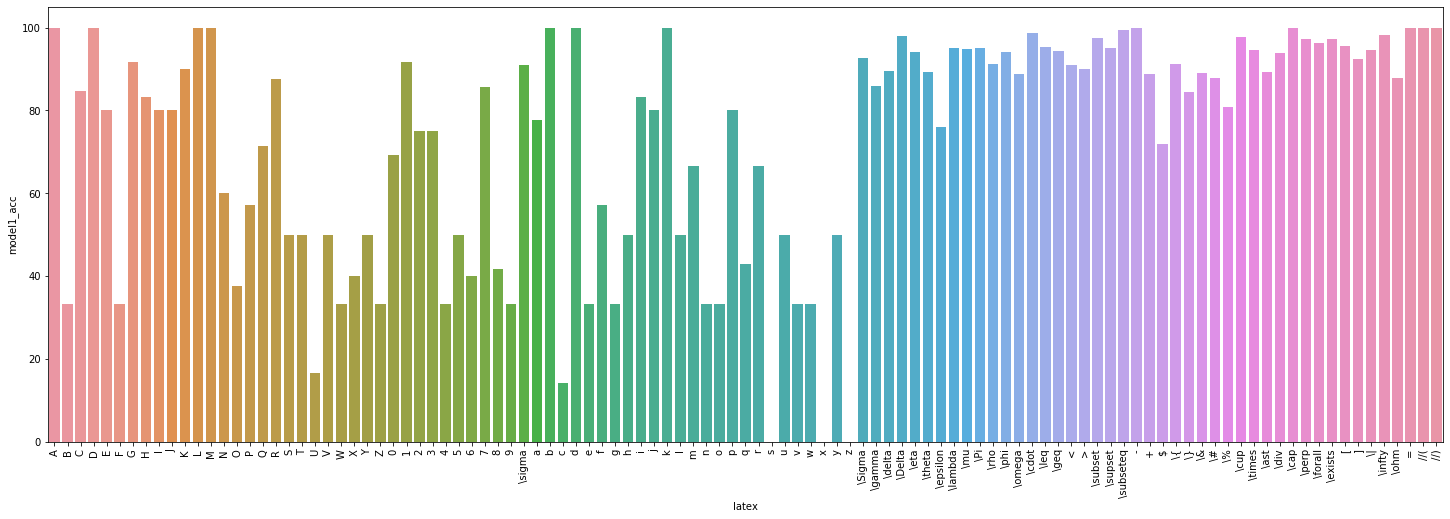

In [69]:
plt.figure(figsize=(25,8))
p = sn.barplot(x='latex', y='model1_acc', data=t_test_report)
_ = plt.setp(p.get_xticklabels(), rotation=90)
plt.savefig('model1_bar_plot')
plt.show()

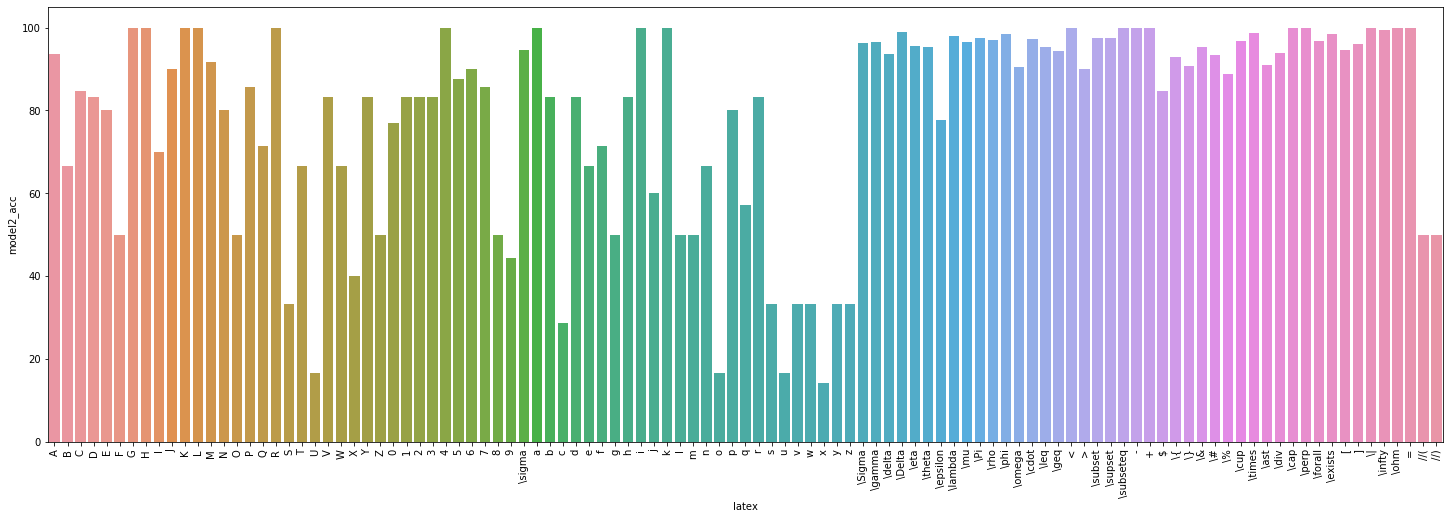

In [70]:
plt.figure(figsize=(25,8))
p = sn.barplot(x='latex', y='model2_acc', data=z)
_ = plt.setp(p.get_xticklabels(), rotation=90)
plt.savefig('model2_bar_plot')
plt.show()

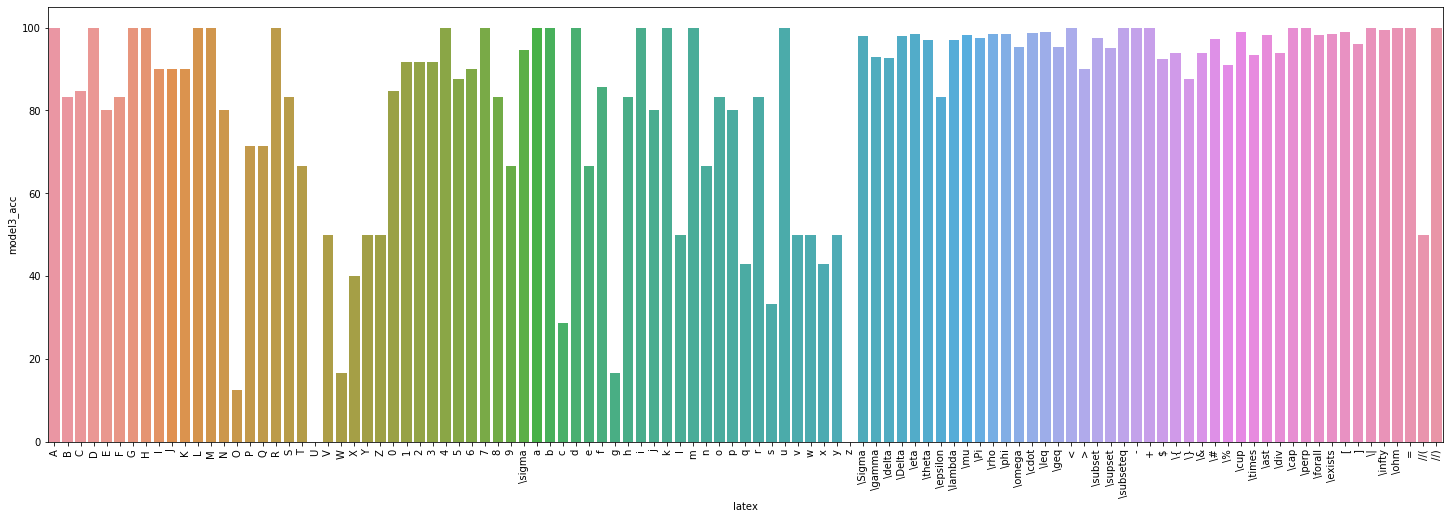

In [71]:
plt.figure(figsize=(25,8))
p = sn.barplot(x='latex', y='model3_acc', data=z)
_ = plt.setp(p.get_xticklabels(), rotation=90)
plt.savefig('model3_bar_plot')
plt.show()

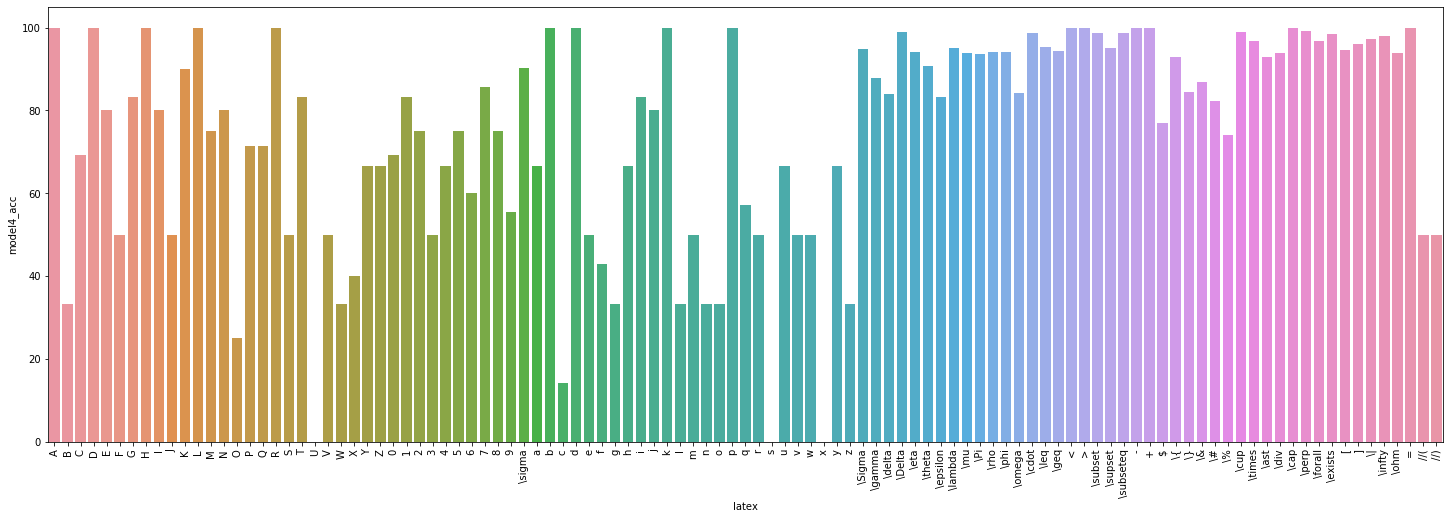

In [72]:
plt.figure(figsize=(25,8))
p = sn.barplot(x='latex', y='model4_acc', data=z)
_ = plt.setp(p.get_xticklabels(), rotation=90)
plt.savefig('model4_bar_plot')
plt.show()

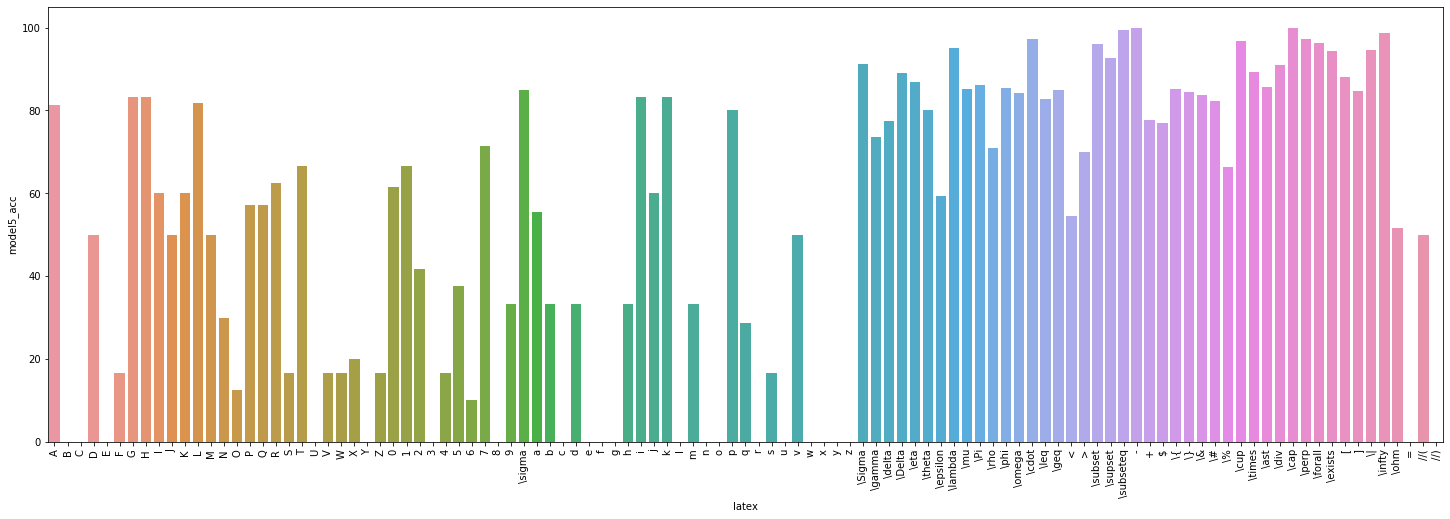

In [73]:
plt.figure(figsize=(25,8))
p = sn.barplot(x='latex', y='model5_acc', data=z)
_ = plt.setp(p.get_xticklabels(), rotation=90)
plt.savefig('model5_bar_plot')
plt.show()

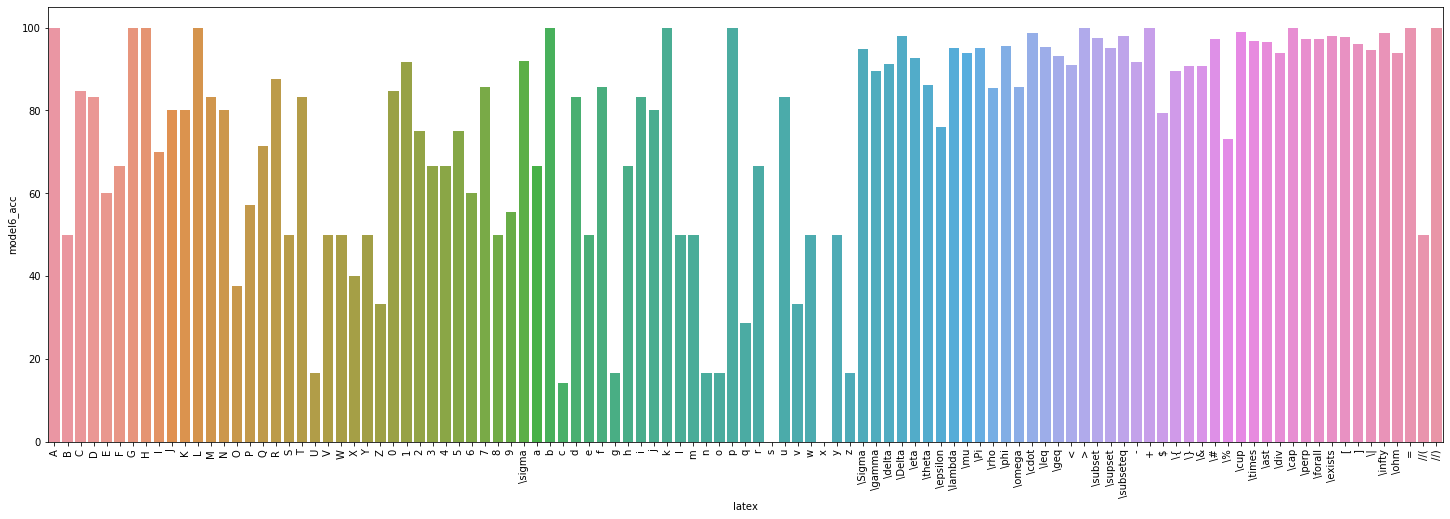

In [74]:
plt.figure(figsize=(25,8))
p = sn.barplot(x='latex', y='model6_acc', data=z)
_ = plt.setp(p.get_xticklabels(), rotation=90)
plt.savefig('model6_bar_plot')
plt.show()

#### Multibar plots

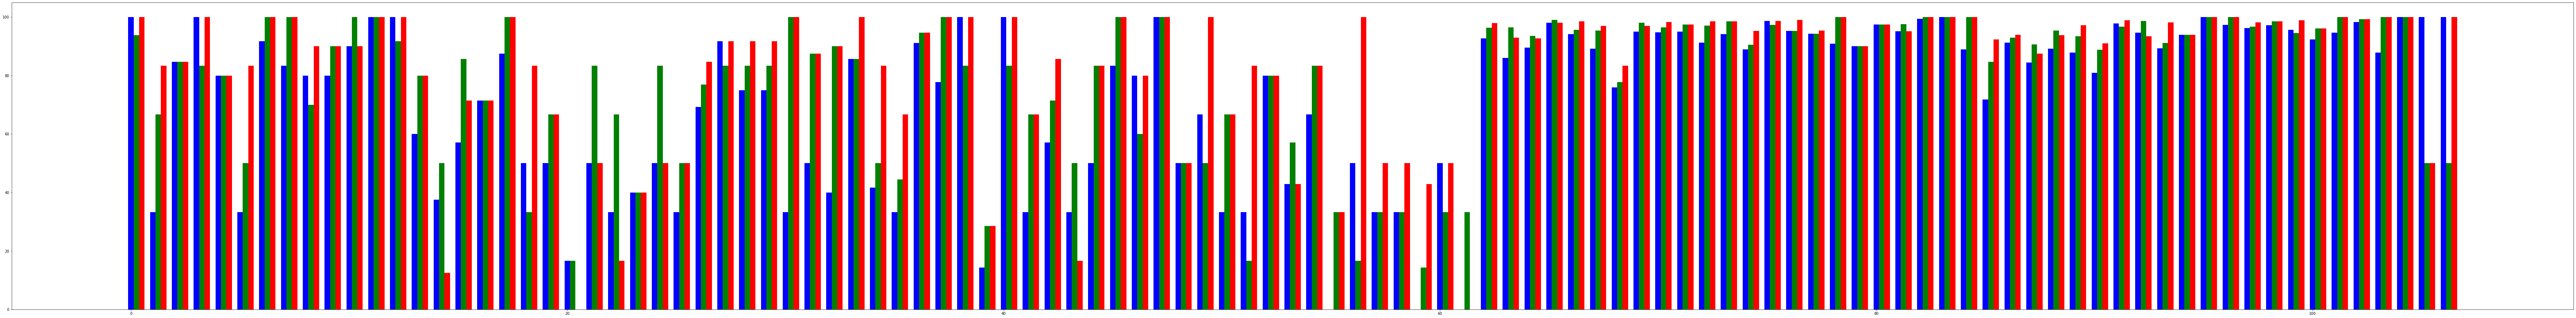

In [111]:
fig = plt.figure(figsize=(100, 12))
ax = fig.add_axes([0,0,1,1])
ax.bar(t_test_report.index + 0.00, t_test_report['model1_acc'], color = 'b', width = 0.25)
ax.bar(t_test_report.index + 0.25, t_test_report['model2_acc'], color = 'g', width = 0.25)
ax.bar(t_test_report.index + 0.50, t_test_report['model3_acc'], color = 'r', width = 0.25)
# plt.legend()
plt.show()

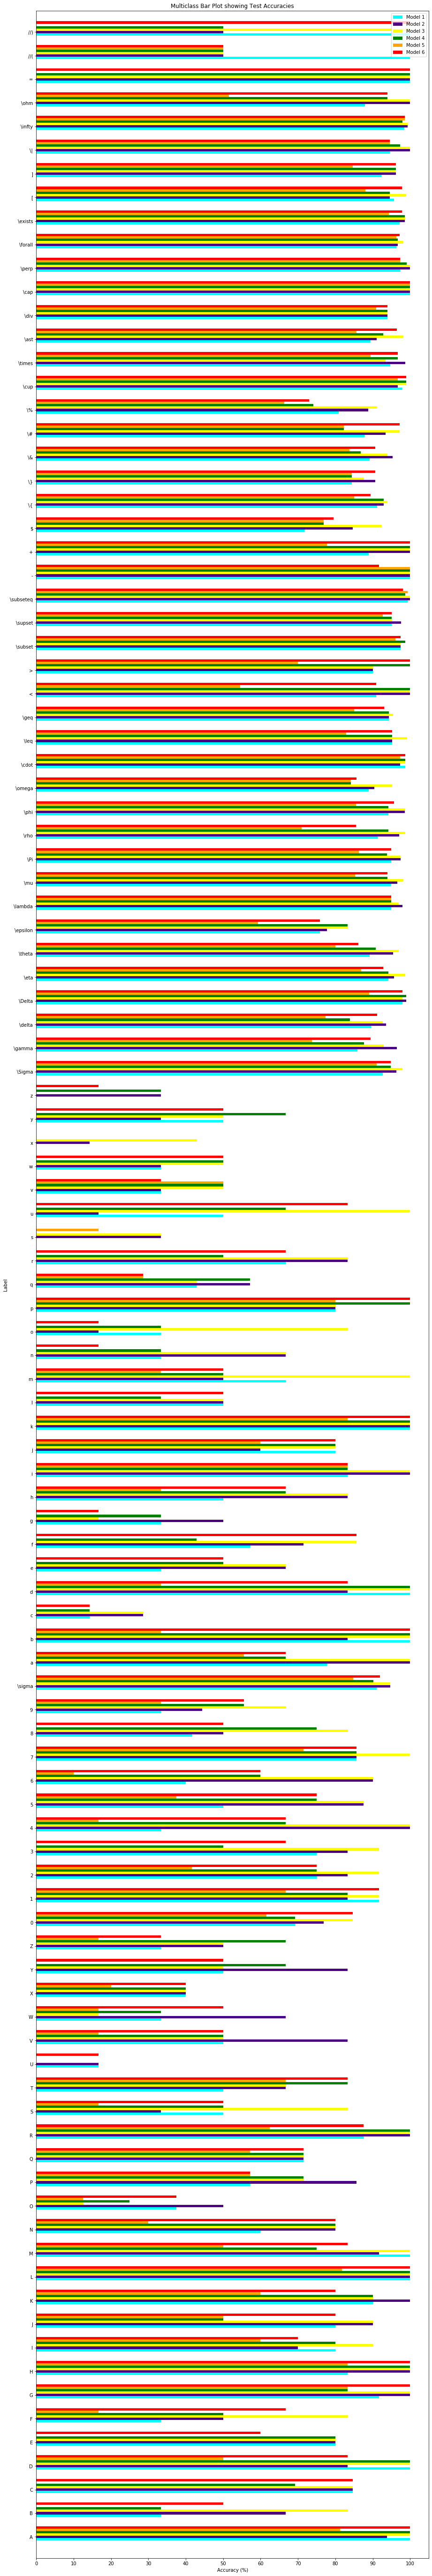

In [115]:
fig, ax = plt.subplots(figsize=(15, 100))
width = 0.1
lbl = np.arange(107)
ax.barh(lbl, t_test_report['model1_acc'], width, color='cyan', label='Model 1')
ax.barh(lbl + width, t_test_report['model2_acc'], width, color='indigo', label='Model 2')
ax.barh(lbl + 2*width, t_test_report['model3_acc'], width, color='yellow', label='Model 3')
ax.barh(lbl + 3*width, t_test_report['model4_acc'], width, color='green', label='Model 4')
ax.barh(lbl + 4*width, t_test_report['model5_acc'], width, color='orange', label='Model 5')
ax.barh(lbl + 5*width, t_test_report['model6_acc'], width, color='red', label='Model 6')
ax.set(yticks=lbl + width, yticklabels=t_test_report['latex'], ylim=[2*width - 1, len(t_test_report)])
ax.set(xticks=range(0, 101, 10))
plt.xlabel('Accuracy (%)')
plt.ylabel('Label')
plt.legend(loc=1)
plt.title('Multiclass Bar Plot showing Test Accuracies')
plt.show()

#### F1-score Plots

Load all classification reports as dicts

In [296]:
# Generate dataframes for all classification reports
df_cr1 = pd.DataFrame(data=cr1).transpose()
df_cr2 = pd.DataFrame(data=cr2).transpose()
df_cr3 = pd.DataFrame(data=cr3).transpose()
df_cr4 = pd.DataFrame(data=cr4).transpose()
df_cr5 = pd.DataFrame(data=cr5).transpose()
df_cr6 = pd.DataFrame(data=cr6).transpose()

df_cr1.drop(labels=['accuracy', 'macro avg', 'weighted avg'], axis=0, inplace=True)
df_cr2.drop(labels=['accuracy', 'macro avg', 'weighted avg'], axis=0, inplace=True)
df_cr3.drop(labels=['accuracy', 'macro avg', 'weighted avg'], axis=0, inplace=True)
df_cr4.drop(labels=['accuracy', 'macro avg', 'weighted avg'], axis=0, inplace=True)
df_cr5.drop(labels=['accuracy', 'macro avg', 'weighted avg'], axis=0, inplace=True)
df_cr6.drop(labels=['accuracy', 'macro avg', 'weighted avg'], axis=0, inplace=True)

symss = symbols['latex'].to_list()

df_cr1['latex'] = symss
df_cr2['latex'] = symss
df_cr3['latex'] = symss
df_cr4['latex'] = symss
df_cr5['latex'] = symss
df_cr6['latex'] = symss

df_cr1.reset_index(drop=True, inplace=True)
df_cr2.reset_index(drop=True, inplace=True)
df_cr3.reset_index(drop=True, inplace=True)
df_cr4.reset_index(drop=True, inplace=True)
df_cr5.reset_index(drop=True, inplace=True)
df_cr6.reset_index(drop=True, inplace=True)

In [297]:
%%capture
"""
# vertical bars

plt.figure(figsize=(25,8))
p = sn.barplot(x='latex', y='f1-score', data=df_cr1)
_ = plt.setp(p.get_xticklabels(), rotation=90)
plt.title('F1-score for Model 1')
plt.xlabel('Label')
plt.ylabel('F1-score')
# plt.savefig(plot_dir+'f1_model1_bar_plot')
plt.show()
"""

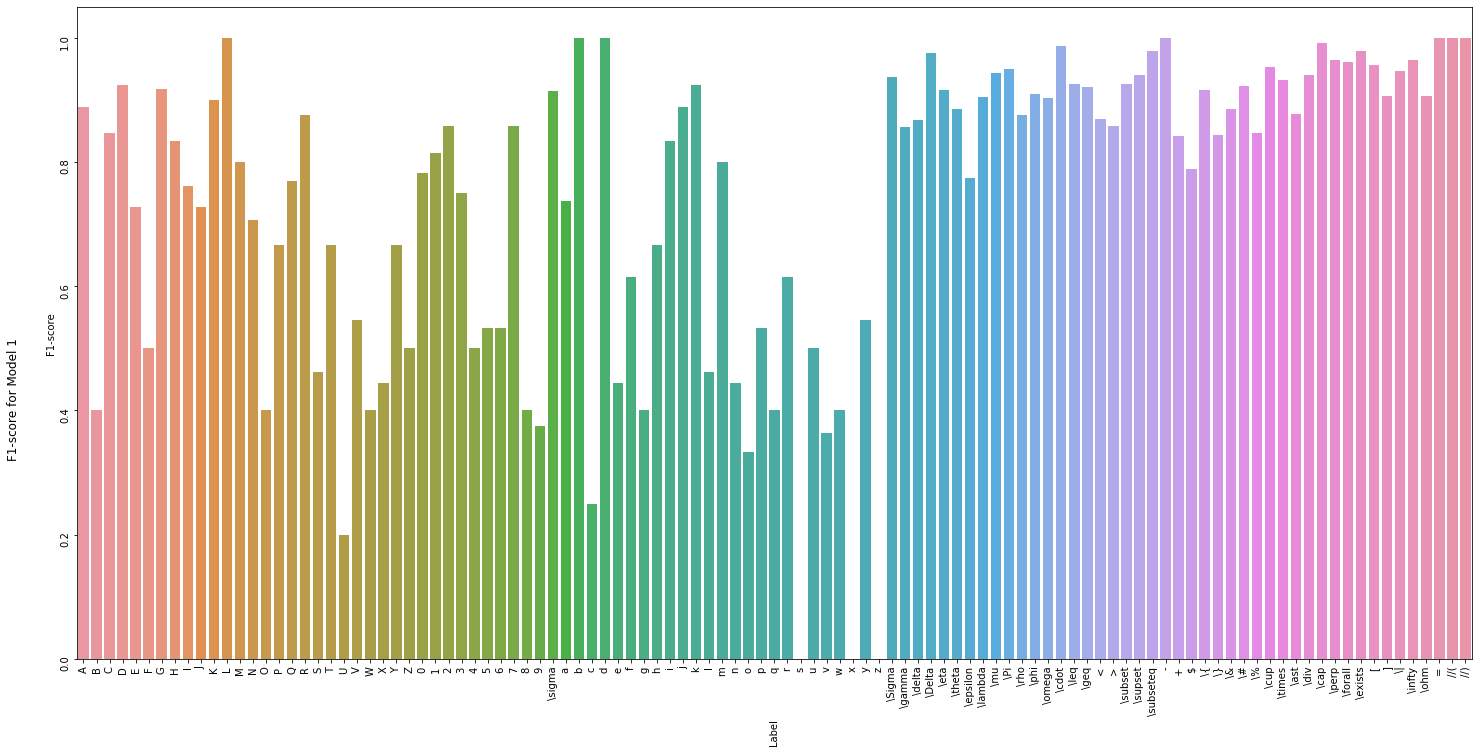

In [118]:
# horizontal barplot
plt.figure(figsize=(25,12))
p = sn.barplot(x='latex', y='f1-score', data=df_cr1)
plt.title('F1-score for Model 1', rotation='90', loc='left', x=-0.05, y=0.3)
plt.xlabel('Label', rotation=90)
plt.ylabel('F1-score')
_ = plt.setp(p.get_xticklabels(), rotation=90)
_ = plt.setp(p.get_yticklabels(), rotation=90)
plt.savefig(plot_dir+'f1_model1_bar_plot', bbox_inches='tight')
plt.show()

In [121]:
%%capture
"""
# vertical bars

plt.figure(figsize=(25,8))
p = sn.barplot(x='latex', y='f1-score', data=df_cr2)
_ = plt.setp(p.get_xticklabels(), rotation=90)
plt.title('F1-score for Model 2')
plt.xlabel('Label')
plt.ylabel('F1-score')
plt.savefig(plot_dir+'f1_model2_bar_plot')
plt.show()
"""

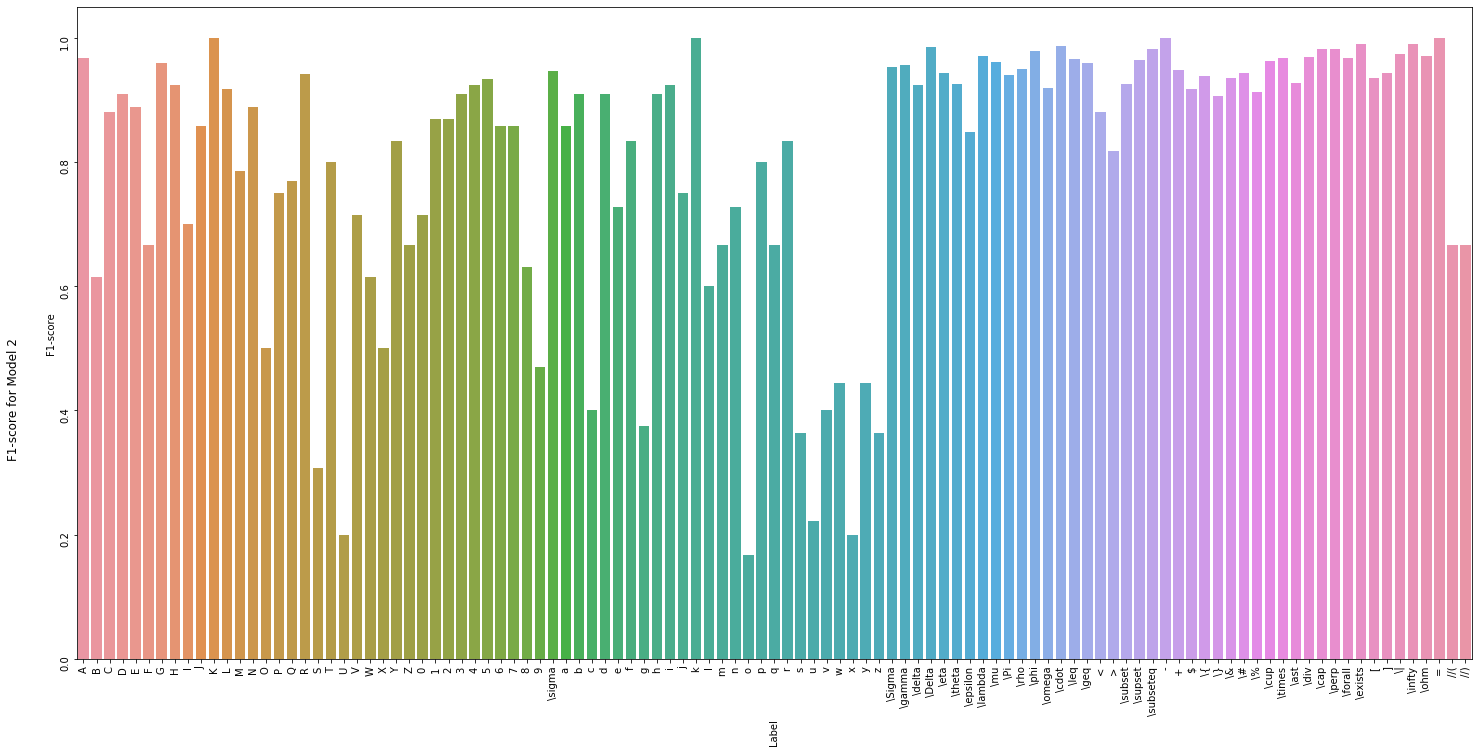

In [119]:
# horizontal barplot
plt.figure(figsize=(25,12))
p = sn.barplot(x='latex', y='f1-score', data=df_cr2)
plt.title('F1-score for Model 2', rotation='90', loc='left', x=-0.05, y=0.3)
plt.xlabel('Label', rotation=90)
plt.ylabel('F1-score')
_ = plt.setp(p.get_xticklabels(), rotation=90)
_ = plt.setp(p.get_yticklabels(), rotation=90)
plt.savefig(plot_dir+'f1_model2_bar_plot', bbox_inches='tight')
plt.show()

In [120]:
%%capture
"""
# vertical bars

plt.figure(figsize=(25,8))
p = sn.barplot(x='latex', y='f1-score', data=df_cr3)
_ = plt.setp(p.get_xticklabels(), rotation=90)
plt.title('F1-score for Model 3')
plt.xlabel('Label')
plt.ylabel('F1-score')
plt.savefig('f1_model3_bar_plot')
plt.show()
"""

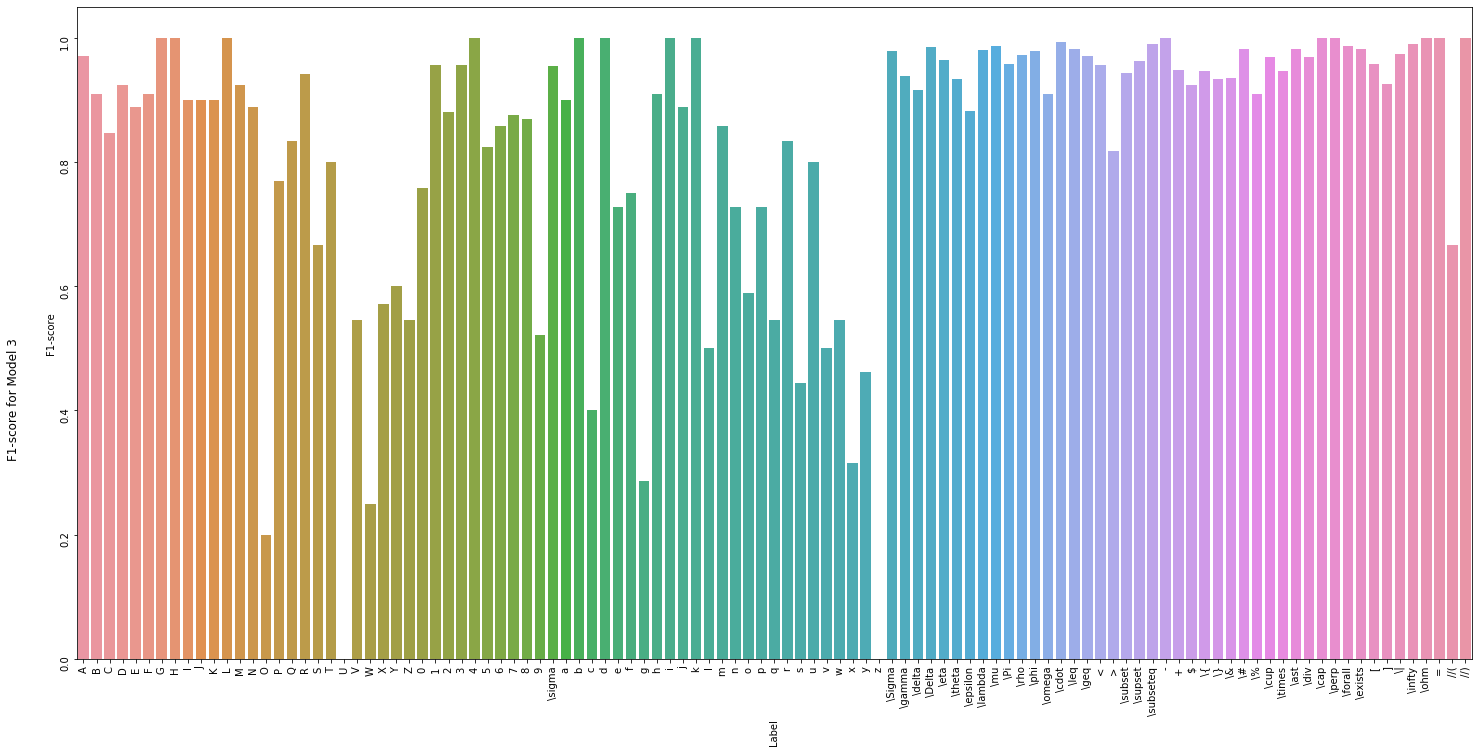

In [122]:
# horizontal barplot
plt.figure(figsize=(25,12))
p = sn.barplot(x='latex', y='f1-score', data=df_cr3)
plt.title('F1-score for Model 3', rotation='90', loc='left', x=-0.05, y=0.3)
plt.xlabel('Label', rotation=90)
plt.ylabel('F1-score')
_ = plt.setp(p.get_xticklabels(), rotation=90)
_ = plt.setp(p.get_yticklabels(), rotation=90)
plt.savefig(plot_dir+'f1_model3_bar_plot', bbox_inches='tight')
plt.show()

In [124]:
%%capture
"""
# vertical bars

plt.figure(figsize=(25,8))
p = sn.barplot(x='latex', y='f1-score', data=df_cr4)
_ = plt.setp(p.get_xticklabels(), rotation=90)
plt.title('F1-score for Model 4')
plt.xlabel('Label')
plt.ylabel('F1-score')
plt.savefig(plot_dir+'f1_model4_bar_plot')
plt.show()
"""

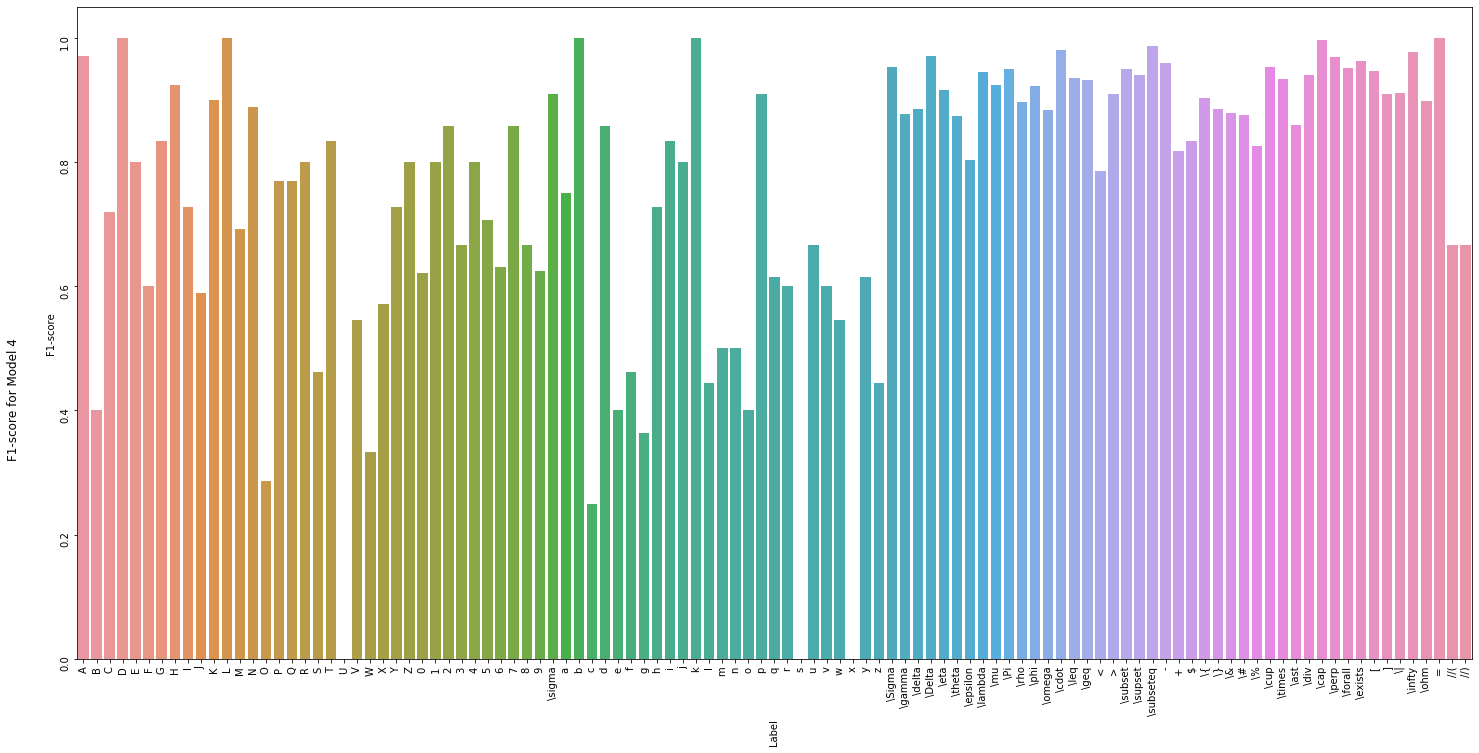

In [125]:
# horizontal barplot
plt.figure(figsize=(25,12))
p = sn.barplot(x='latex', y='f1-score', data=df_cr4)
plt.title('F1-score for Model 4', rotation='90', loc='left', x=-0.05, y=0.3)
plt.xlabel('Label', rotation=90)
plt.ylabel('F1-score')
_ = plt.setp(p.get_xticklabels(), rotation=90)
_ = plt.setp(p.get_yticklabels(), rotation=90)
plt.savefig(plot_dir+'f1_model4_bar_plot', bbox_inches='tight')
plt.show()

In [126]:
%%capture
"""
# vertical bars

plt.figure(figsize=(25,8))
p = sn.barplot(x='latex', y='f1-score', data=df_cr5)
_ = plt.setp(p.get_xticklabels(), rotation=90)
plt.title('F1-score for Model 5')
plt.xlabel('Label')
plt.ylabel('F1-score')
plt.savefig(plot_dir+'f1_model5_bar_plot')
plt.show()
"""

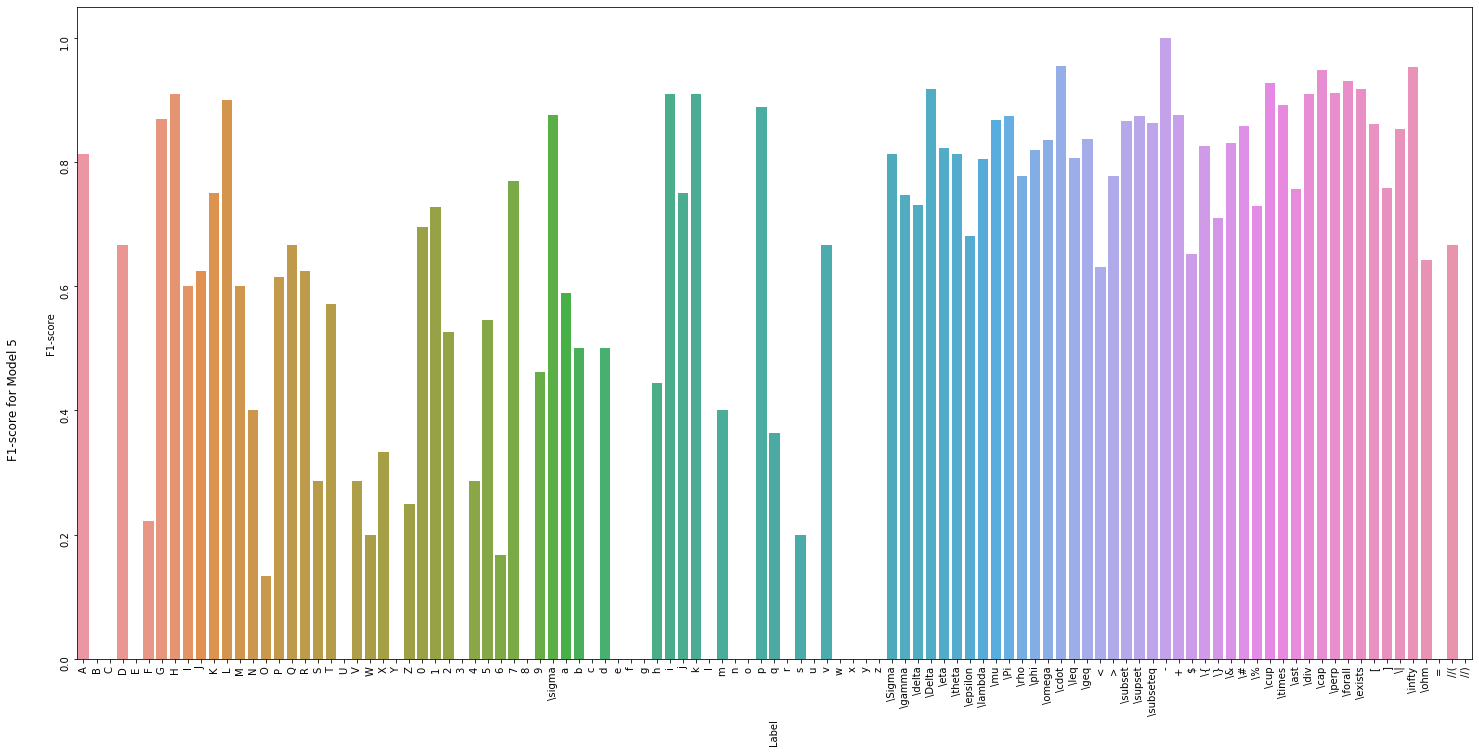

In [127]:
# horizontal barplot
plt.figure(figsize=(25,12))
p = sn.barplot(x='latex', y='f1-score', data=df_cr5)
plt.title('F1-score for Model 5', rotation='90', loc='left', x=-0.05, y=0.3)
plt.xlabel('Label', rotation=90)
plt.ylabel('F1-score')
_ = plt.setp(p.get_xticklabels(), rotation=90)
_ = plt.setp(p.get_yticklabels(), rotation=90)
plt.savefig(plot_dir+'f1_model5_bar_plot', bbox_inches='tight')
plt.show()

In [128]:
%%capture
"""
# vertical bars

plt.figure(figsize=(25,8))
p = sn.barplot(x='latex', y='f1-score', data=df_cr6)
_ = plt.setp(p.get_xticklabels(), rotation=90)
plt.title('F1-score for Model 6')
plt.xlabel('Label')
plt.ylabel('F1-score')
plt.savefig(plot_dir+'f1_model6_bar_plot')
plt.show()
"""

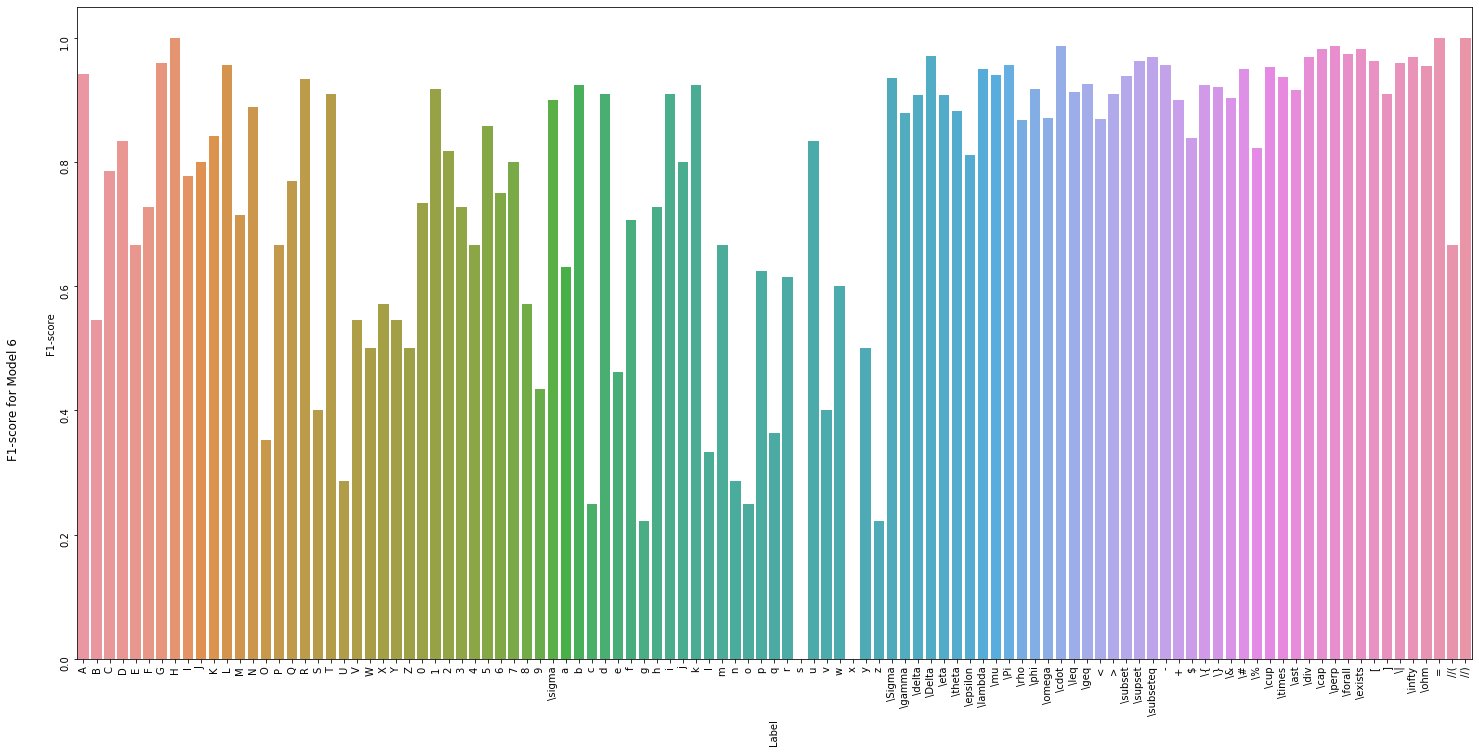

In [129]:
# horizontal barplot
plt.figure(figsize=(25,12))
p = sn.barplot(x='latex', y='f1-score', data=df_cr6)
plt.title('F1-score for Model 6', rotation='90', loc='left', x=-0.05, y=0.3)
plt.xlabel('Label', rotation=90)
plt.ylabel('F1-score')
_ = plt.setp(p.get_xticklabels(), rotation=90)
_ = plt.setp(p.get_yticklabels(), rotation=90)
plt.savefig(plot_dir+'f1_model6_bar_plot', bbox_inches='tight')
plt.show()

In [70]:
%%capture
"""
fig, ax = plt.subplots(figsize=(15, 100))
width = 0.1
lbl = np.arange(107)
ax.barh(lbl, t_test_report['model1_acc'], width, color='cyan', label='Model 1')
ax.barh(lbl + width, t_test_report['model2_acc'], width, color='indigo', label='Model 2')
ax.set(yticks=lbl + width, yticklabels=t_test_report['latex'], ylim=[2*width - 1, len(t_test_report)])
ax.set(xticks=range(0, 101, 10))
plt.xlabel('Accuracy (%)')
plt.ylabel('Label')
plt.legend(loc=1)
plt.title('Multiclass Bar Plot showing Test Accuracies')
plt.show()
"""

<Figure size 432x288 with 0 Axes>

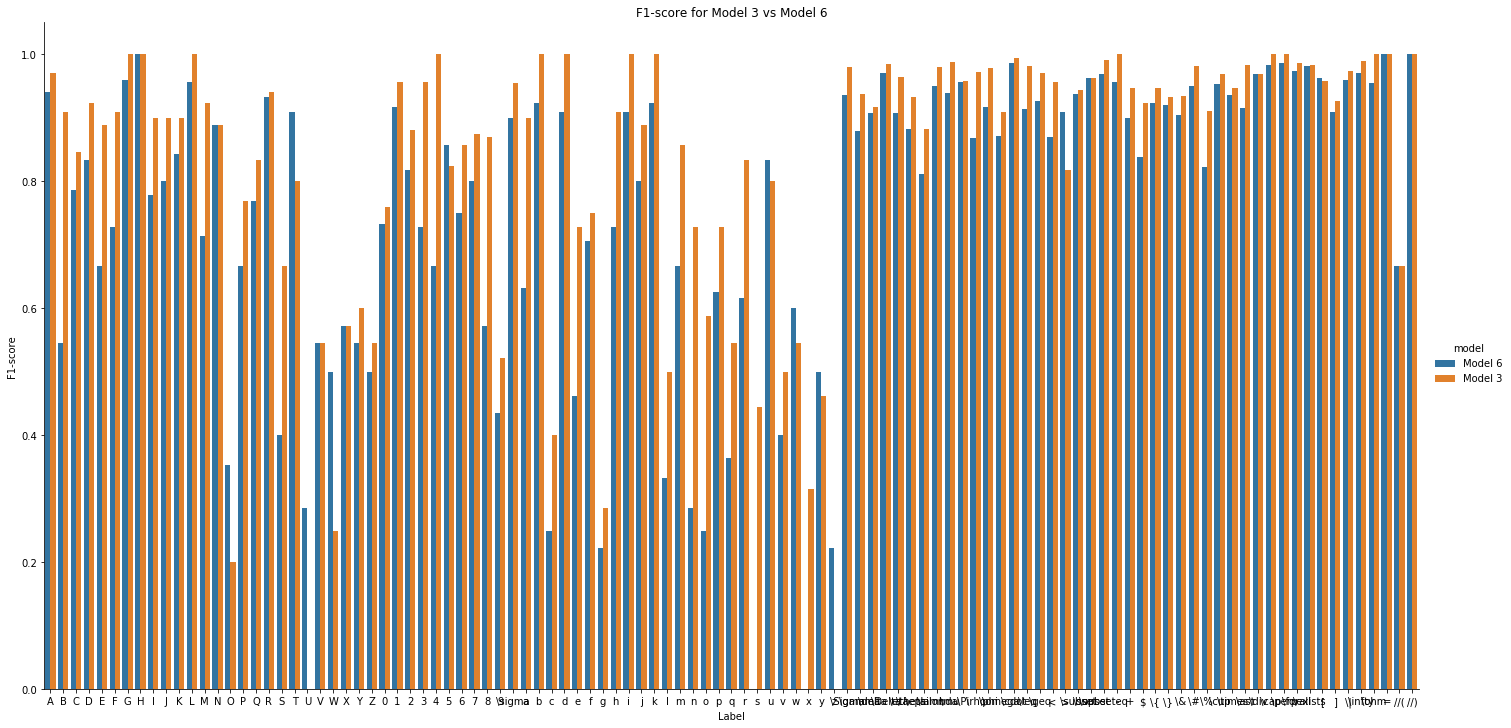

In [71]:
# Not required now
cr36 = df_cr3.copy()
cr36['model'] = ['Model 3' for i in range(len(cr36))]
cr63 = df_cr6.copy()
cr63['model'] = ['Model 6' for i in range(len(cr63))]
cr3v6 = pd.concat([cr63, cr36], axis=0).reset_index(drop=True)

# plot mutibar plot
plt.figure()
p = sn.catplot(x='latex', y='f1-score', hue='model', data=cr3v6, kind='bar', height=10, aspect=2)
# sns.factorplot(x="model", y="f1-score", col="latex", data=cr3v6, kind="bar")
# _ = plt.setp(p.get_xticklabels(), rotation=90)
plt.title('F1-score for Model 3 vs Model 6')
plt.xlabel('Label')
plt.ylabel('F1-score')
plt.savefig(plot_dir+'f1_model3v6_bar_plot')
plt.show()

Find the model which scored highest F1-score for each class

In [298]:
# find model with highest f1 scores
df_f1 =  pd.DataFrame(data = symbols['latex'])
df_f1['model'] = [[-1] for i in range(len(df_f1))]
df_f1['f1-score'] = [-1 for i in range(len(df_f1))]

for i in range(len(df_f1)):
    for m, j in enumerate([df_cr1, df_cr2, df_cr3, df_cr4, df_cr5, df_cr6]):
        if j.loc[i, 'f1-score'] > df_f1.loc[i, 'f1-score']:
            df_f1['model'][i] = [m+1]
            df_f1.loc[i, 'f1-score'] = j.loc[i, 'f1-score']
        elif j.loc[i, 'f1-score'] == df_f1.loc[i, 'f1-score']:
            df_f1['model'][i].append(m+1)

In [299]:
m_count = {k:0 for k in range(1, 7)}
for i in df_f1['model']:
    for j in i:
        m_count[j] += 1

In [300]:
pprint(m_count)

{1: 19, 2: 36, 3: 67, 4: 18, 5: 1, 6: 11}


#### Comparison of validation accuracy

In [8]:
log_dir = model_dir + 'logs/'

In [13]:
df_history1 = pd.read_csv(log_dir+'logs_model1.csv').drop('Unnamed: 0', axis=1).reset_index(drop=True)
df_history2 = pd.read_csv(log_dir+'logs_model2.csv').drop('Unnamed: 0', axis=1).reset_index(drop=True)
df_history3 = pd.read_csv(log_dir+'logs_model3.csv').drop('Unnamed: 0', axis=1).reset_index(drop=True)
df_history4 = pd.read_csv(log_dir+'logs_model4.csv').drop('Unnamed: 0', axis=1).reset_index(drop=True)
df_history5 = pd.read_csv(log_dir+'logs_model5.csv').drop('Unnamed: 0', axis=1).reset_index(drop=True)
df_history6 = pd.read_csv(log_dir+"logs_model6.csv").drop('Unnamed: 0', axis=1).reset_index(drop=True)

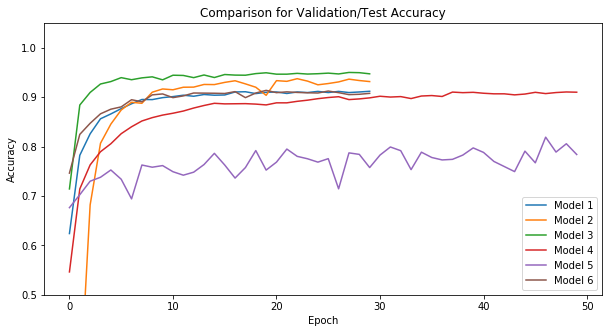

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(df_history1['val_acc'], label='Model 1')
plt.plot(df_history2['val_acc'], label='Model 2')
plt.plot(df_history3['val_acc'], label='Model 3')
plt.plot(df_history4['val_acc'], label='Model 4')
plt.plot(df_history5['val_acc'], label='Model 5')
plt.plot(df_history6['val_acc'], label='Model 6')
plt.title('Comparison for Validation/Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.05])
plt.legend(loc='lower right')
plt.savefig(plot_dir+'val_acc_comparison_plot.png', bbox_inches='tight')
plt.show()

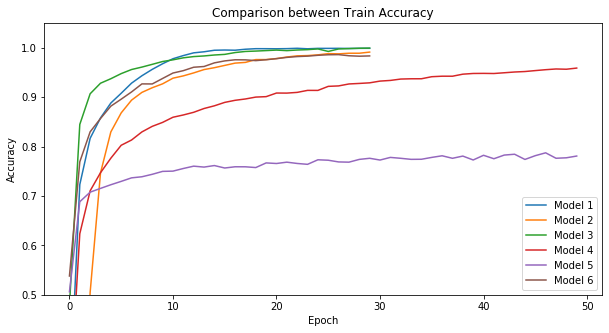

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(df_history1['acc'], label='Model 1')
plt.plot(df_history2['acc'], label='Model 2')
plt.plot(df_history3['acc'], label='Model 3')
plt.plot(df_history4['acc'], label='Model 4')
plt.plot(df_history5['acc'], label='Model 5')
plt.plot(df_history6['acc'], label='Model 6')
plt.title('Comparison between Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.05])
plt.legend(loc='lower right')
plt.savefig(plot_dir+'train_acc_comparison_plot.png', bbox_inches='tight')
plt.show()